In [345]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian
from scipy.signal import find_peaks

# Medición de ancho (wave driver):

Usé este mismo código para sacar el ancho en px de 1) el palito en la superficie del experimento del wave driver que usamos como referencia 2) diámetro de los filamentos en las fotos que sacó Miguel en el microscopio. 

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\pauli\AppData\Local\Temp\ipykernel_8728\4048285388.py:1: SyntaxWarning: invalid escape sequence '\c'
  im = cv2.imread('fotos\calibracion filamento microscopio\\filamento-x10.tif')


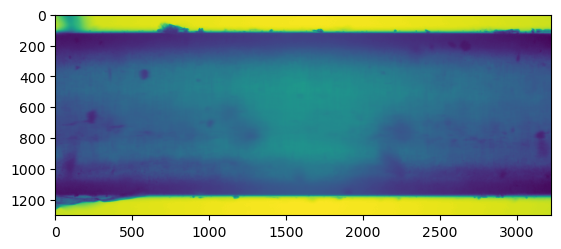

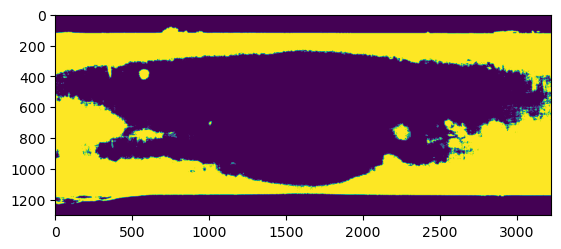

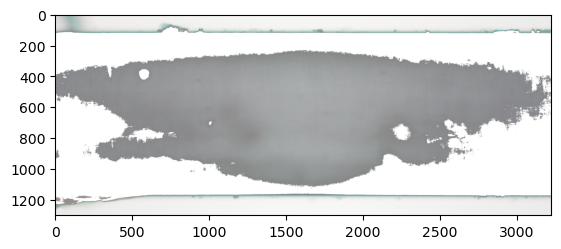

In [ ]:
im = cv2.imread('fotos\calibracion filamento microscopio\\filamento-x10.tif')

im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(im_gs)

_, im_th = cv2.threshold(im_gs, 135, 255, cv2.THRESH_BINARY)

# p/ remito_dado_vuelta: 75 de threshold
# p/ filamento-x10: 135

im_th = cv2.bitwise_not(im_th)

y, x  = np.where(im_th == 255)

im_show = im.copy()

im_show[y, x] = 255
plt.figure()
plt.imshow(im_th)
np.shape(im_th)

plt.figure()
plt.imshow(im_show)

918 1103


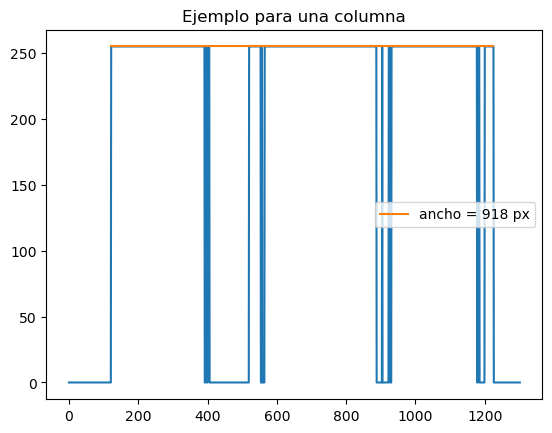

In [10]:
col = im_th[:,0]
bar = np.where(col==255)[0]
width = bar[-1] - bar[0]
print(len(bar), width)

plt.plot(col)
plt.title('Ejemplo para una columna')
plt.plot([bar[0], bar[-1]], [255, 255], label=f'ancho = {len(bar)} px')
plt.legend()

In [11]:
cols = [im_th[:, i] for i in range(np.shape(im_th)[1])]
len(cols)

widths = []
widths2 = []
for c in cols:
    bar = np.where(c==255)[0]
    width2 = len(bar)
    width = bar[-1] - bar[0]
    widths.append(width)
    widths2.append(width2)

mean_width = np.mean(widths)
width_err = np.std(widths)/np.sqrt(len(widths))

mean_width2 = np.mean(widths2)
width2_err = np.std(widths2)/np.sqrt(len(widths2))

In [15]:
# FILAMENTOS:

UM_PER_PX = 0.4245033304856029
UM_PER_PX_ERROR = 0.00020834189731838294

print(np.shape(im_th))
print(f'Ancho en píxeles del filamento: {mean_width} +- {width_err}\nAncho en micrones: {mean_width*UM_PER_PX} +- {width_err*UM_PER_PX + mean_width*UM_PER_PX_ERROR}')


(1302, 3222)
Ancho en píxeles del filamento: 1055.7330850403475 +- 0.279206893027264
Ancho en micrones: 448.16221070346774 +- 0.33847768998370675


In [ ]:
WIDTH_CUERPO = 2.36
width_calibre_err = 0
WIDTH_CABEZA = 6.79

PX_PER_MM2 = mean_width2/WIDTH_CABEZA
ERR_PX_MM2 = width2_err/WIDTH_CABEZA

# print(f'ancho promedio: {mean_width} +- {width_err}')
# print(f'px per mm: {PX_PER_MM} +- {ERR_PX_MM}')

print(f'ancho2 promedio: {mean_width2} +- {width2_err}')
print(f'px per mm: {PX_PER_MM2} +- {ERR_PX_MM2}')

# print(width2_err/width_calibre, np.std(widths2)/width_calibre)

ancho2 promedio: 32.97560975609756 +- 0.017034885262672637
px per mm: 4.856496282194044 +- 0.002508819626314085


# Diámetro del filamento para cada video

Ancho en px de los filamentos para cada uno de los videos de laboratorio 7

In [346]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian
import DSE_prune
from skimage.measure import label, regionprops, regionprops_table

THRESHOLD = 100
MAX_PIXEL_VALUE = 255
DIAMETRO_UM = 447.34452755946927
DIAMETRO_MM = DIAMETRO_UM*1e-3

In [5]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, th=THRESHOLD, PRUEBA=False, nombre='BINARY'):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    # esto cierra los globitos, es lo que faltaba antes:
    # for c in np.unique(x):
    #     r = np.where(sk[:, c]!=0)[0]
    #     for p in r:
    #         sk[p, c] = 0
    #     sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

In [18]:
# itero y saco un frame de trabajo por cada video:

import os
import pandas as pd

for filename in os.listdir('videos\\FCD\\P1\\telgopor'):
    vs = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\'+filename)
    lim = [0, 1280, 110, 600] #[xleft, xright, ytop, ydown]
    length = int(vs.get(cv.CAP_PROP_FRAME_COUNT))
    i = 0
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            if i == length//2:
                frame = cortar(frame, lim)
                # Guardo las fotos
                spl = filename[:-4].split('-')
                v,f = spl[1],spl[2]
                cv.imwrite(f'fotos\\capturas calibracion\\captura-{v}-{f}.tiff', frame)
                print(f'guardado: {filename}')
                break
            i+=1
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Hubo un problema que se yo", filename)
            break
    print('siguiente')

cv.destroyAllWindows()

guardado: P1-1V-10Hz-60mm.mp4
siguiente
guardado: P1-1V-15Hz-60mm.mp4
siguiente
guardado: P1-1V-5Hz-60mm.mp4
siguiente
guardado: P1-2V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-15Hz-60mm.mp4
siguiente
guardado: P1-2V-5Hz-60mm.mp4
siguiente
guardado: P1-3V-10Hz-60mm.mp4
siguiente
guardado: P1-3V-5Hz-60mm.mp4
siguiente
guardado: P1-4V-5Hz-60mm.mp4
siguiente
siguiente


In [353]:
problematicos = ['P1-3V-10Hz-60mm.mp4', 'P1-2V-10Hz-60mm.mp4', 'P1-1V-10Hz-60mm.mp4', 'P1-2V-15Hz-60mm.mp4']

for filename in problematicos:
    vs = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\'+filename)
    lim = [0, 1280, 110, 600] #[xleft, xright, ytop, ydown]
    length = int(vs.get(cv.CAP_PROP_FRAME_COUNT))
    i = 0
    while(vs.isOpened()):
        ret, frame = vs.read()
        if ret:
            if i == 2*(length//3):
                frame = cortar(frame, lim)
                # frame = gris(frame)
                # Guardo las fotos
                spl = filename[:-4].split('-')
                v,f = spl[1],spl[2]
                cv.imwrite(f'fotos\\capturas calibracion\\captura-{v}-{f}.tiff', frame)
                print(f'guardado: {filename}')
                break
            i+=1
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            print("Hubo un problema que se yo", filename)
            break
    print('siguiente')

cv.destroyAllWindows()

guardado: P1-3V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-10Hz-60mm.mp4
siguiente
guardado: P1-1V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-15Hz-60mm.mp4
siguiente


OSError: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`

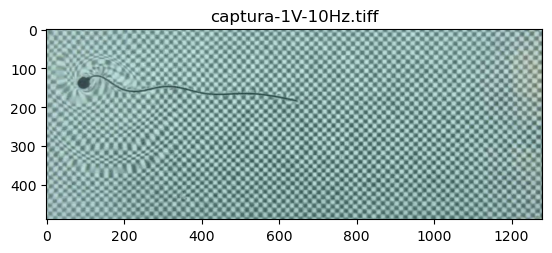

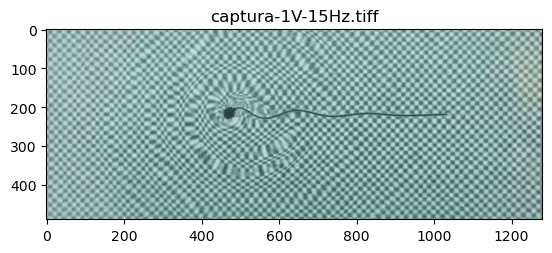

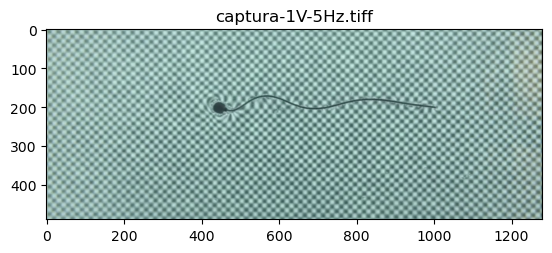

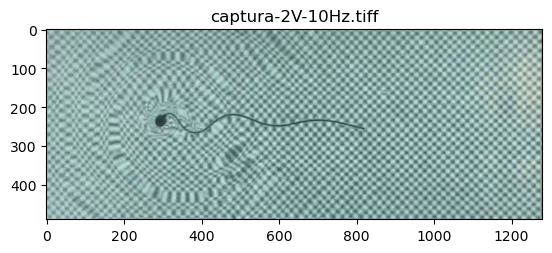

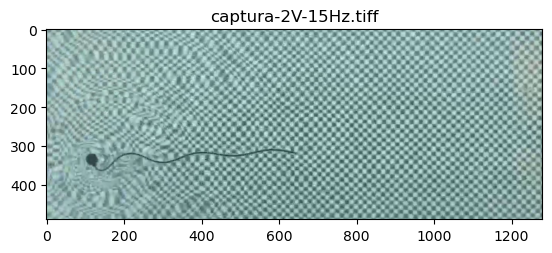

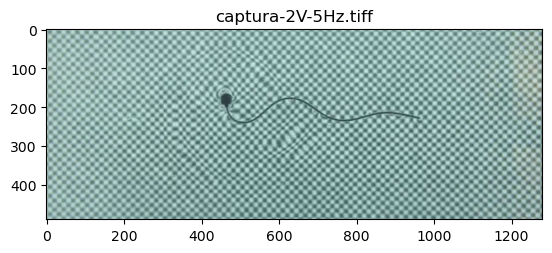

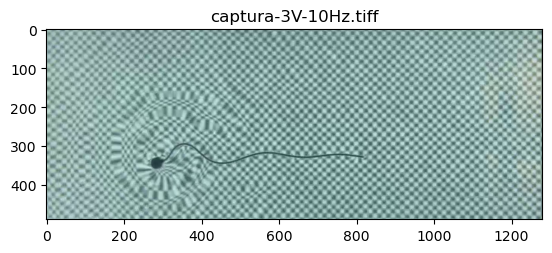

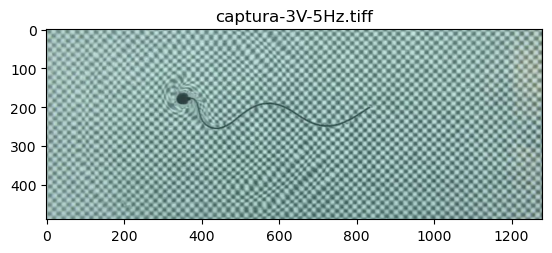

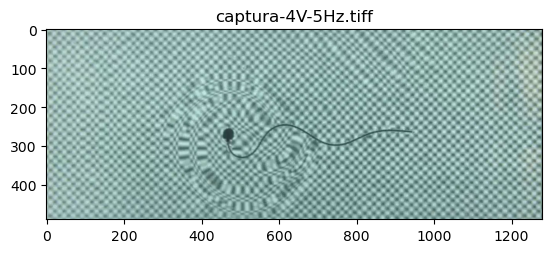

In [354]:
for filename in os.listdir('fotos\\capturas calibracion'):
    captura = skimage.io.imread(f'fotos\\capturas calibracion\\{filename}')
    plt.figure()
    plt.title(f'{filename}')
    plt.imshow(captura)

### Prueba del tratado de la imagen

In [154]:
from skimage.morphology import binary_dilation

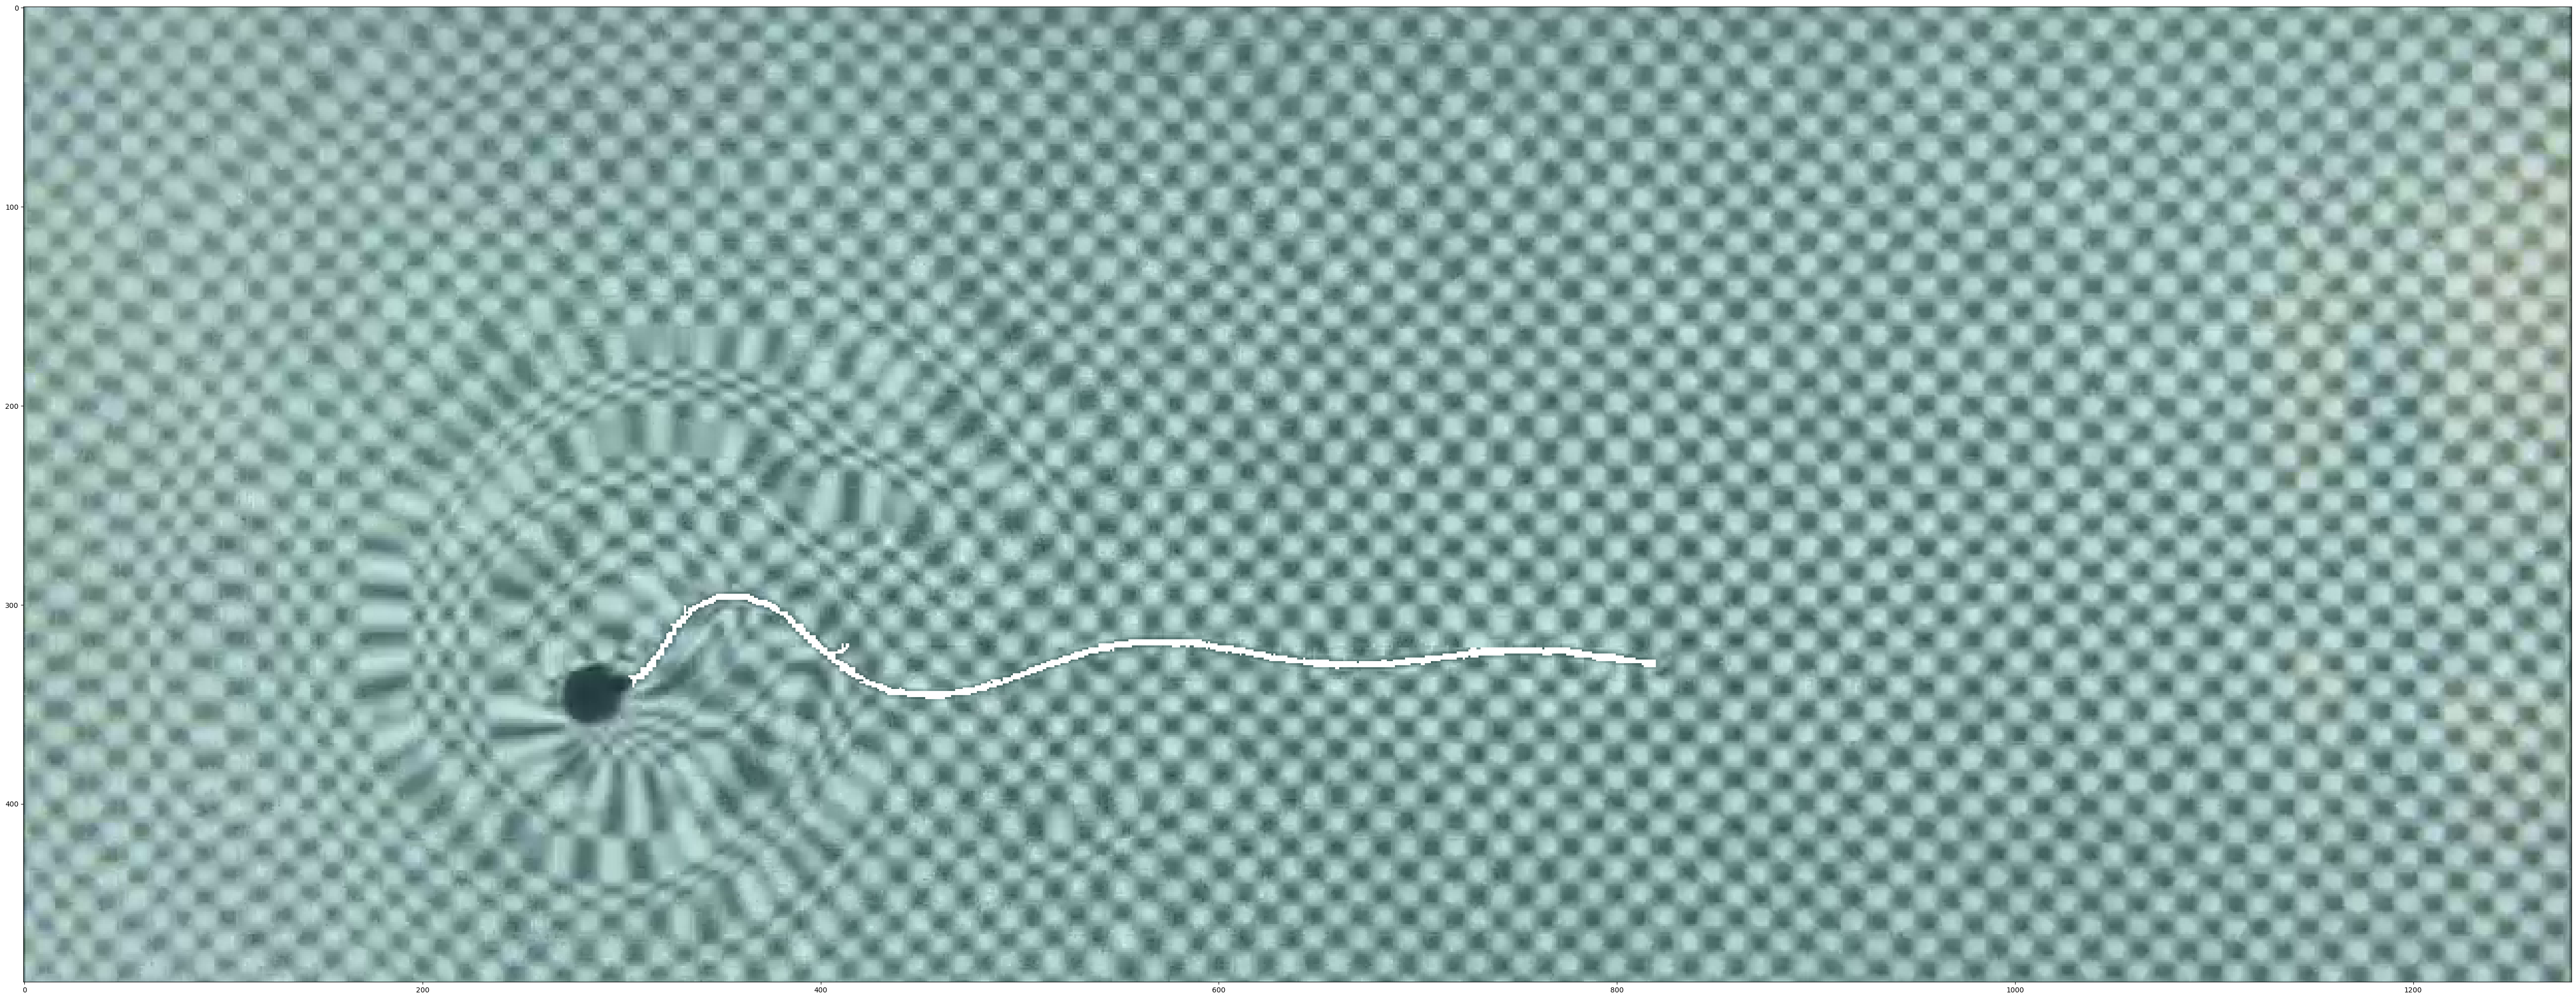

In [423]:
filename = '3V-10Hz'
im = skimage.io.imread(f'fotos\\capturas calibracion\\captura-{filename}.tiff')

# saco la cabeza:

ref_gray = gris(im)

frame_gaussian = gaussian(ref_gray, 4)
frame_binary = 255 - binarize(frame_gaussian, th=0.45)
labeled_image, count = label(1-frame_binary, connectivity=1, return_num=True)               
object_features = skimage.measure.regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
mask = np.zeros_like(labeled_image)
mask += (labeled_image==n+1).astype(int)
mask = binary_dilation(binary_dilation(mask))
y, x = np.where(mask!=0)

ref_gray[y, x] = np.mean(ref_gray)

# LO QUE CAMBIA QUE TAN ANCHO SALE ES EL THRESHOLD ACÁ
# _, ref_bin = cv.threshold(ref_gray, 130, MAX_PIXEL_VALUE, cv.THRESH_BINARY)


# acá 7, 12 funciona bien para todos menos 2V-15Hz (usé 9,8)
ref_bin = cv.adaptiveThreshold(ref_gray,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,7,12)



# ref_bin = cv.adaptiveThreshold(ref_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,17,7)

labeled_image = label(1-ref_bin, connectivity=1)
regions = regionprops(labeled_image)
object_features = skimage.measure.regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
mask = np.zeros_like(labeled_image)
mask += (labeled_image==n+1).astype(int)
area  =  mask

y, x = np.where(area!=0)

line_th, dist = skimage.morphology.medial_axis(area, return_distance=True)
y_sk, x_sk = np.where(line_th!=0)

im[y, x] = [255,255,255]
# im[y_sk, x_sk] = [0,0,255]
# 
plt.figure(figsize=(300, 25))
plt.imshow(im)


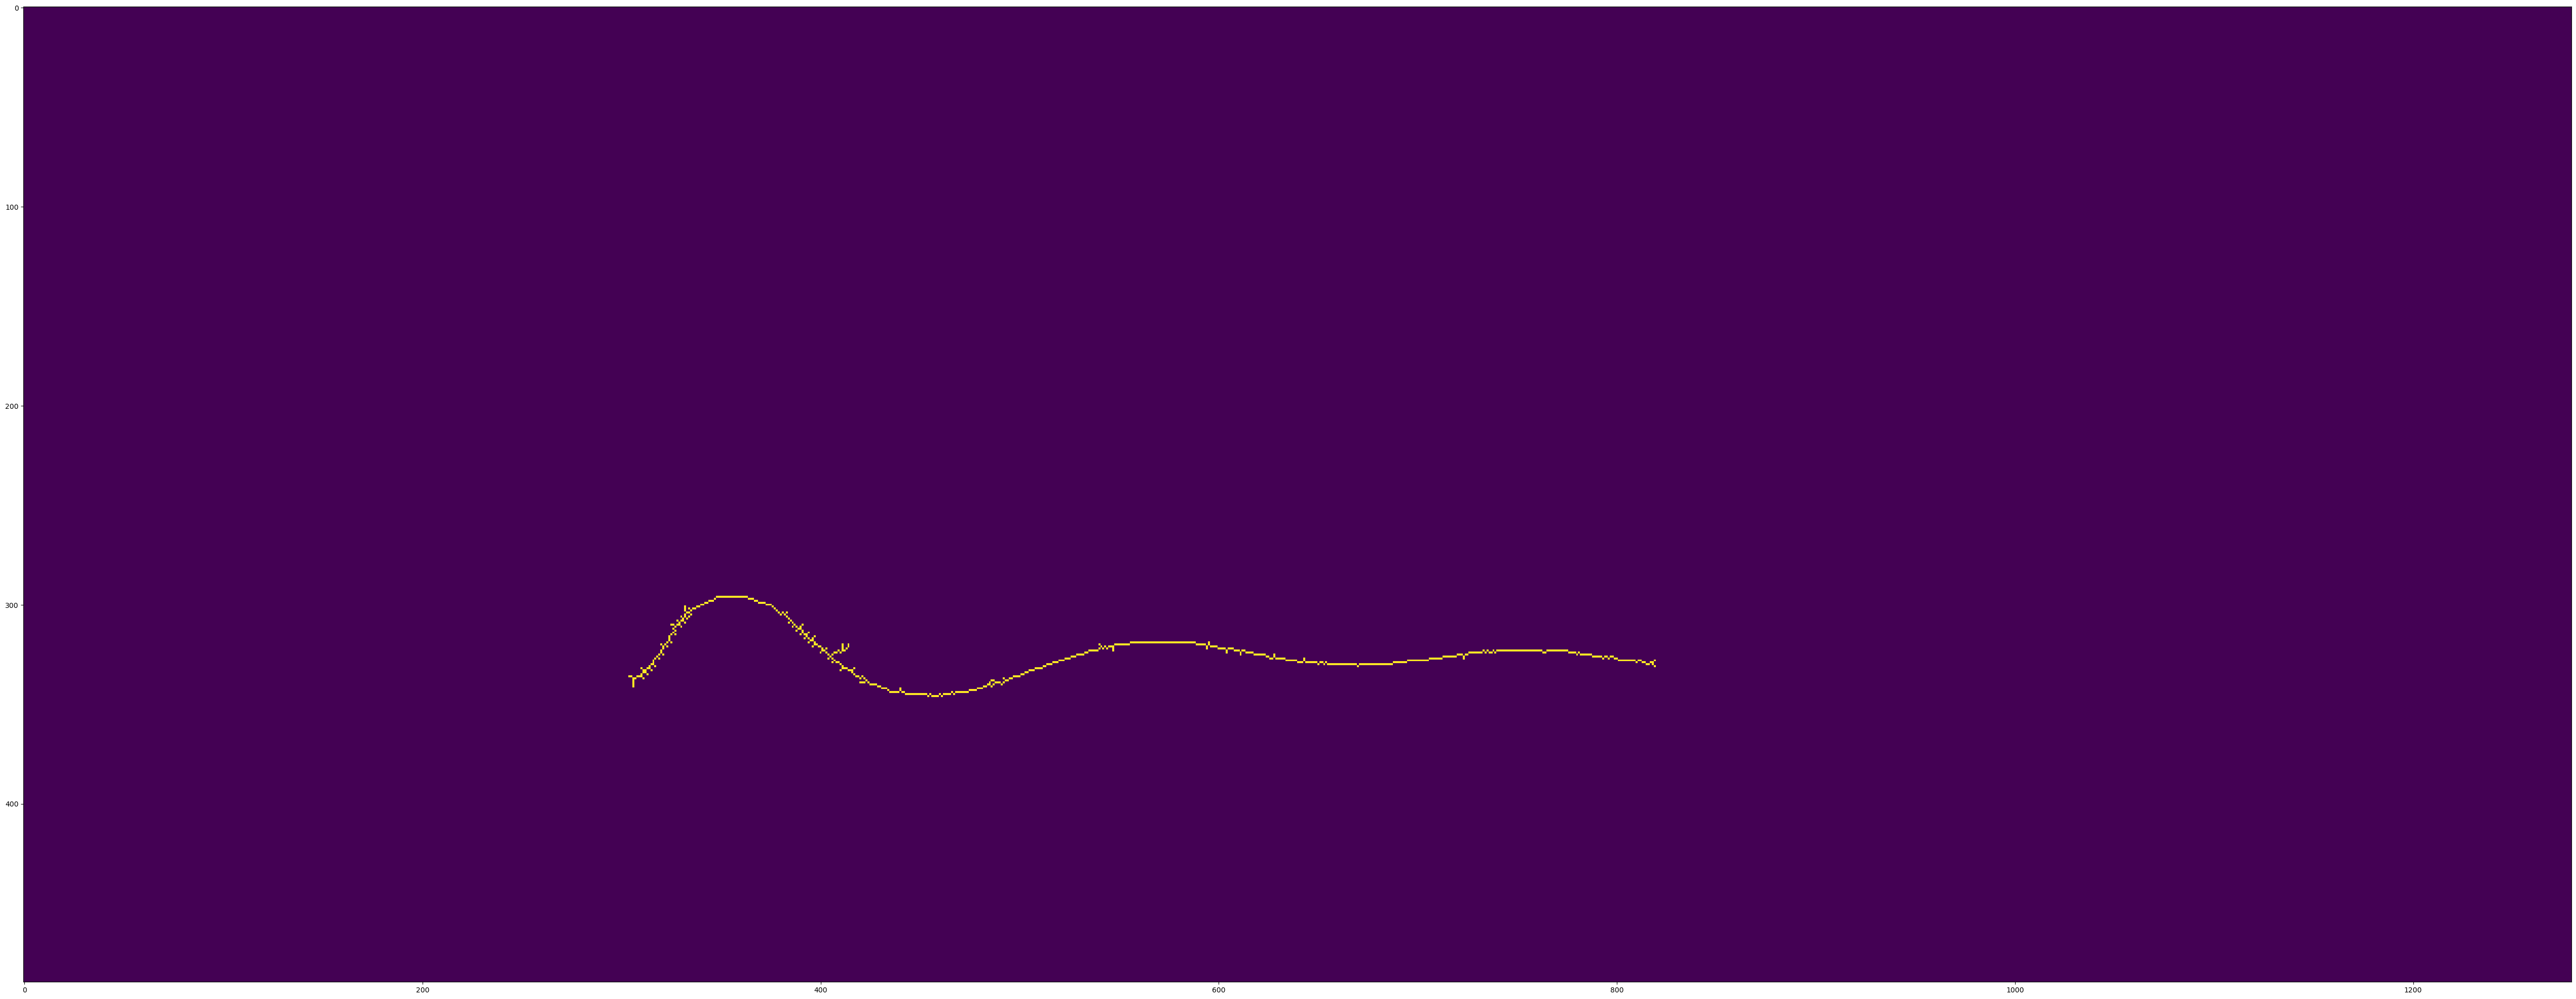

In [424]:
plt.figure(figsize=(300, 25))
plt.imshow(line_th)

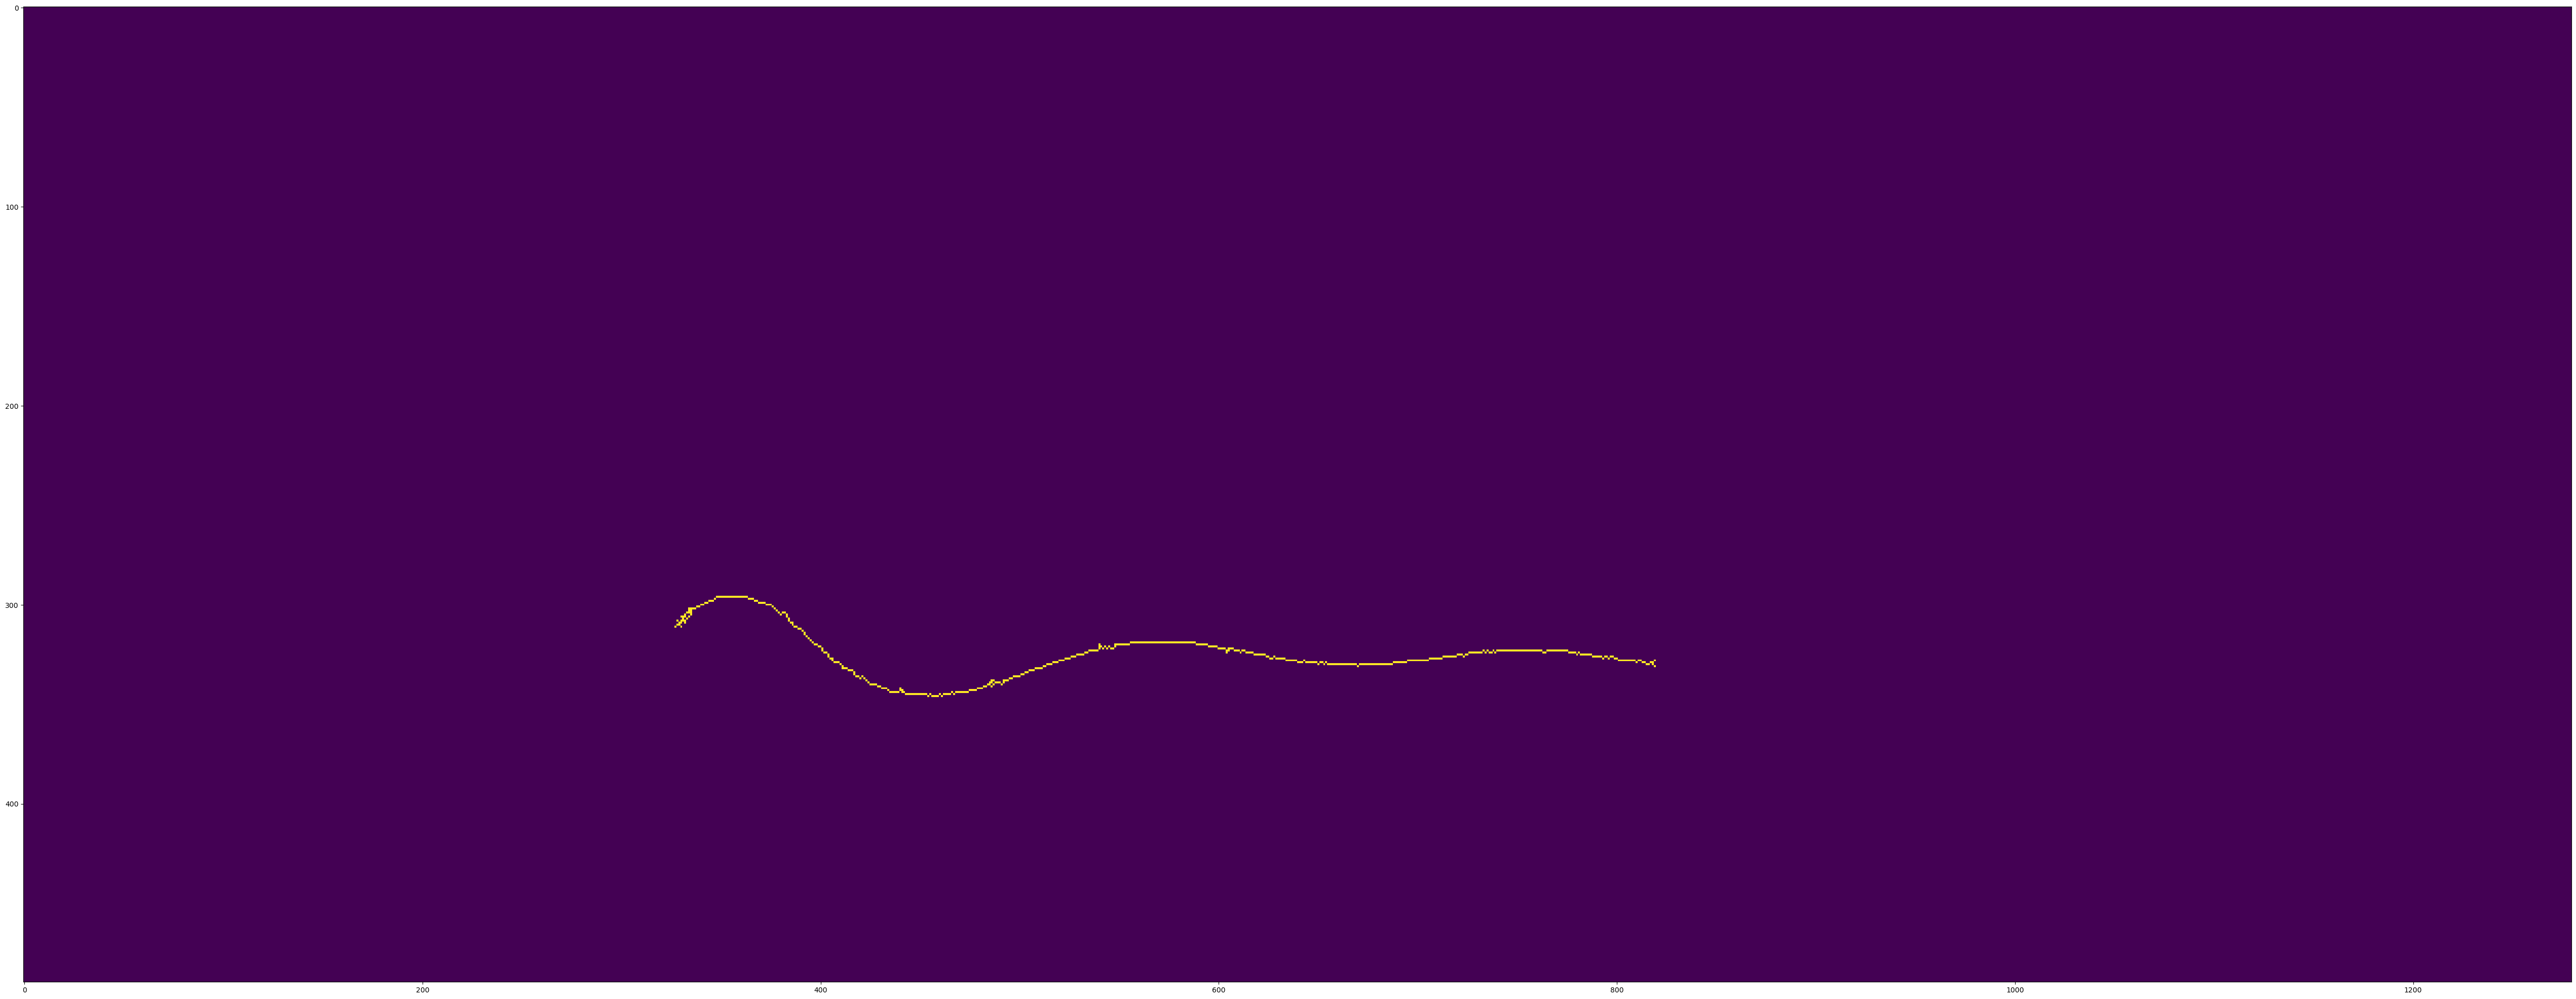

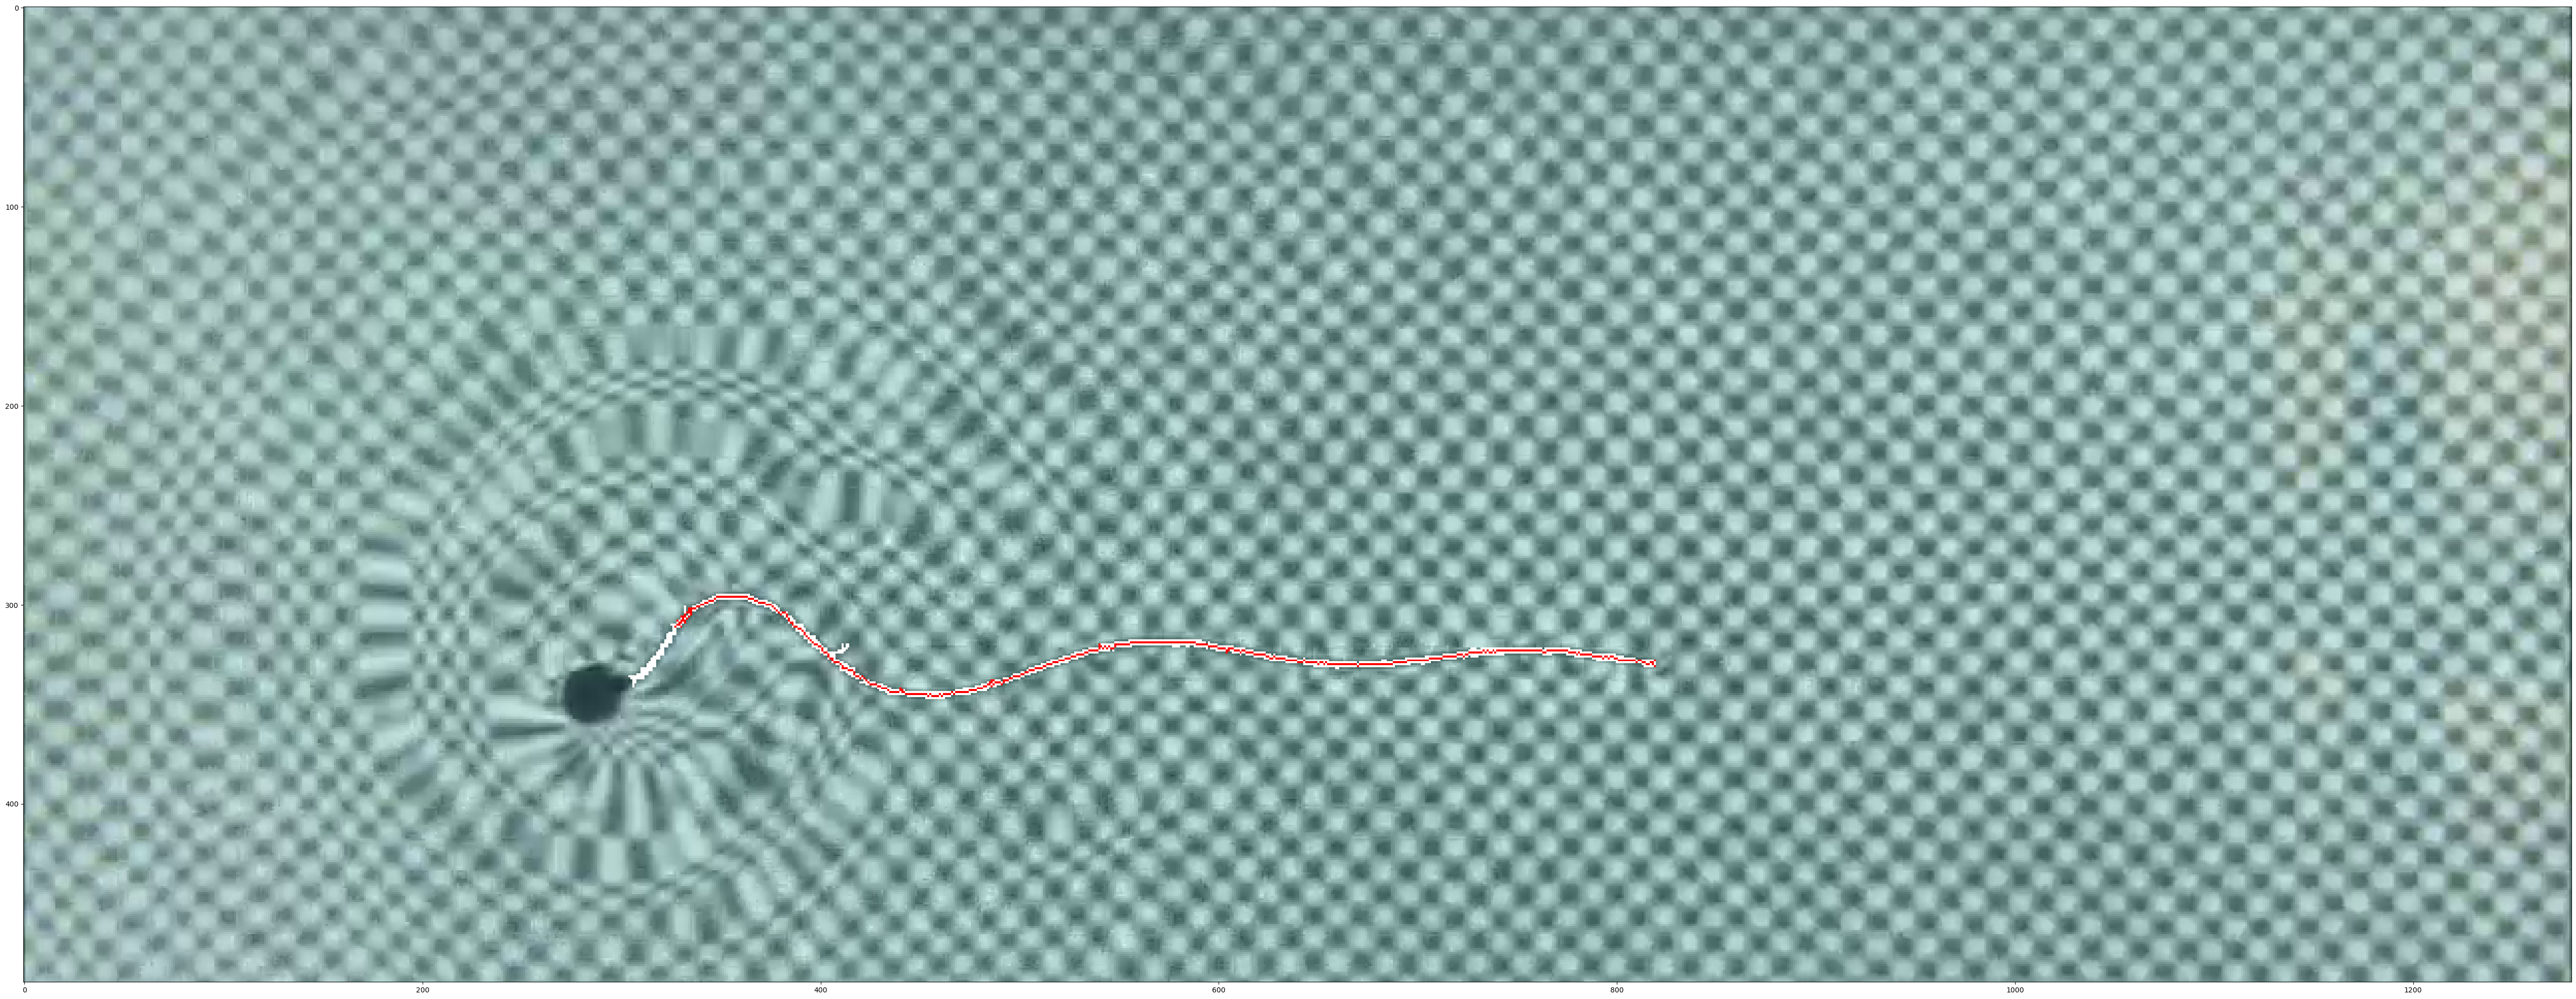

In [425]:
ref_DSE = DSE_prune.skel_pruning_DSE(line_th, dist, 200)
y_DSE, x_DSE = np.where(ref_DSE!=0)

im[y_DSE, x_DSE] = [255,0,0]
plt.figure(figsize=(300, 25))
plt.imshow(ref_DSE)


plt.figure(figsize=(300, 25))
plt.imshow(im)

In [426]:
new_list = []

for x, y in zip(x_DSE, y_DSE):
    new_list.append((x, y))

new_list = sorted(new_list, key=lambda element: element[0])

x_DSE_sorted,y_DSE_sorted = [], []

for x, y in new_list:
    x_DSE_sorted.append(x)
    y_DSE_sorted.append(y)

In [211]:
from skimage.measure import profile_line

[[array([327, 298]), array([339, 313])], [array([339, 280]), array([352, 316])], [array([352, 376]), array([364, 216])], [array([364, 314]), array([377, 285])], [array([377, 315]), array([390, 298])], [array([390, 324]), array([402, 311])], [array([402, 337]), array([415, 319])], [array([415, 347]), array([427, 325])], [array([427, 368]), array([440, 314])], [array([440, 381]), array([453, 307])], [array([453, 258]), array([465, 430])], [array([465, 294]), array([478, 392])], [array([478, 310]), array([491, 371])], [array([491, 323]), array([503, 350])], [array([503, 313]), array([516, 350])], [array([516, 310]), array([528, 344])], [array([528, 301]), array([541, 344])], [array([541, 266]), array([554, 375])], [array([554, 239]), array([566, 399])], [array([579, 399]), array([591, 239])], [array([591, 348]), array([604, 294])], [array([604, 388]), array([617, 258])], [array([617, 353]), array([629, 297])], [array([629, 377]), array([642, 278])], [array([642, 386]), array([655, 271])],

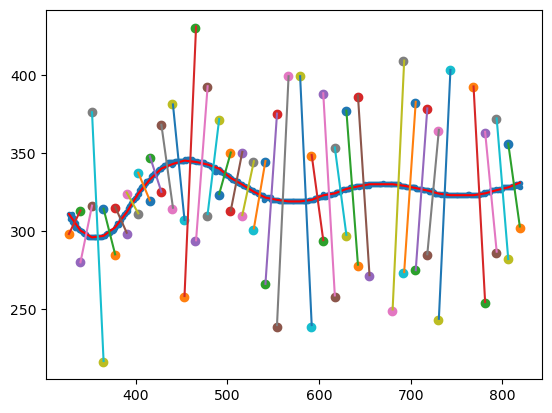

In [427]:
plt.figure()
plt.plot(x_DSE, y_DSE, '.')

x_interp = np.linspace(x_DSE_sorted[0], x_DSE_sorted[-1], 40)
y_interp = np.interp(x_interp, x_DSE_sorted, y_DSE_sorted)

a = []
div_0 = []
for i in range(len(x_interp)-1):
    resta = np.diff(y_interp)[i]/np.diff(x_interp)[i]
    if resta == 0:
        resta = 1e-10
        div_0.append(i)
    a.append(resta)               

uno_sobre_a = -1/np.array(a)

def lineal(x, m, x0, y0):
    return m*(x-x0) + y0

x_lineales = [np.linspace(x_interp[i], x_interp[i+1], 100) for i in range(len(x_interp)-1)]

plt.plot(x_interp, y_interp, 'r')

line_coordinates = []

for i, x_array in enumerate(x_lineales):
    if i not in div_0:
        y_array = lineal(x_array, uno_sobre_a[i], (x_interp[i]+x_interp[i+1])/2, (y_interp[i]+y_interp[i+1])/2)
        start = np.array([int(x_array[0]), int(y_array[0])])
        end = np.array([int(x_array[-1]), int(y_array[-1])])
        line_coordinates.append([start, end])
        plt.plot(start[0], start[1], 'o')
        plt.plot(end[0], end[1], 'o')
        plt.plot(x_array, y_array)

print(line_coordinates)

# plt.plot(x_interp, y_interp, 'b')

In [428]:
perfil = profile_line(area, line_coordinates[4][0], line_coordinates[4][1])

perfiles = []

for coord in line_coordinates:
    # area[coord[1][1], coord[1][0]] = 1
    # area[coord[0][1], coord[0][0]] = 1
    perfil = profile_line(area, np.array([coord[0][1], coord[0][0]]), np.array([coord[1][1], coord[1][0]]))
    perfiles.append(perfil)

anchos = [np.sum(perfil) for perfil in perfiles]
diametro = np.mean(anchos)



print(f'El ancho en píxeles es de: {np.mean(anchos)} +- {np.std(anchos)/len(anchos)}')
print(f'Los píxeles por mm son {np.mean(anchos)/DIAMETRO_MM} +- {np.std(anchos)/len(anchos)/DIAMETRO_MM}')


# plt.figure(figsize=(300, 25))
# plt.imshow(area)

El ancho en píxeles es de: 3.8529411764705883 +- 0.03200692041522491
Los píxeles por mm son 8.612916754544145 +- 0.07154870227169585


In [ ]:
cv.imwrite(f'fotos\\capturas calibracion\\perfil-{filename}', area)

True

In [161]:
data = pd.read_csv('datos\\Plot Values-3V-5Hz.csv')
px, value = data['Distance_(pixels)'], data['Gray_Value']

In [163]:
sides = np.where(value==0)[0]
diff = np.diff(sides)
DIAMETRO_PX = np.max(diff)
PX_PER_MM = 6/DIAMETRO_MM
err = 1/DIAMETRO_MM
print(f'{filename}\npx por mm: {PX_PER_MM} +- {err}')

captura-3V-5Hz.tiff
px por mm: 13.412481052877906 +- 2.235413508812984


### Máquina de sacar diámetros

OSError: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`

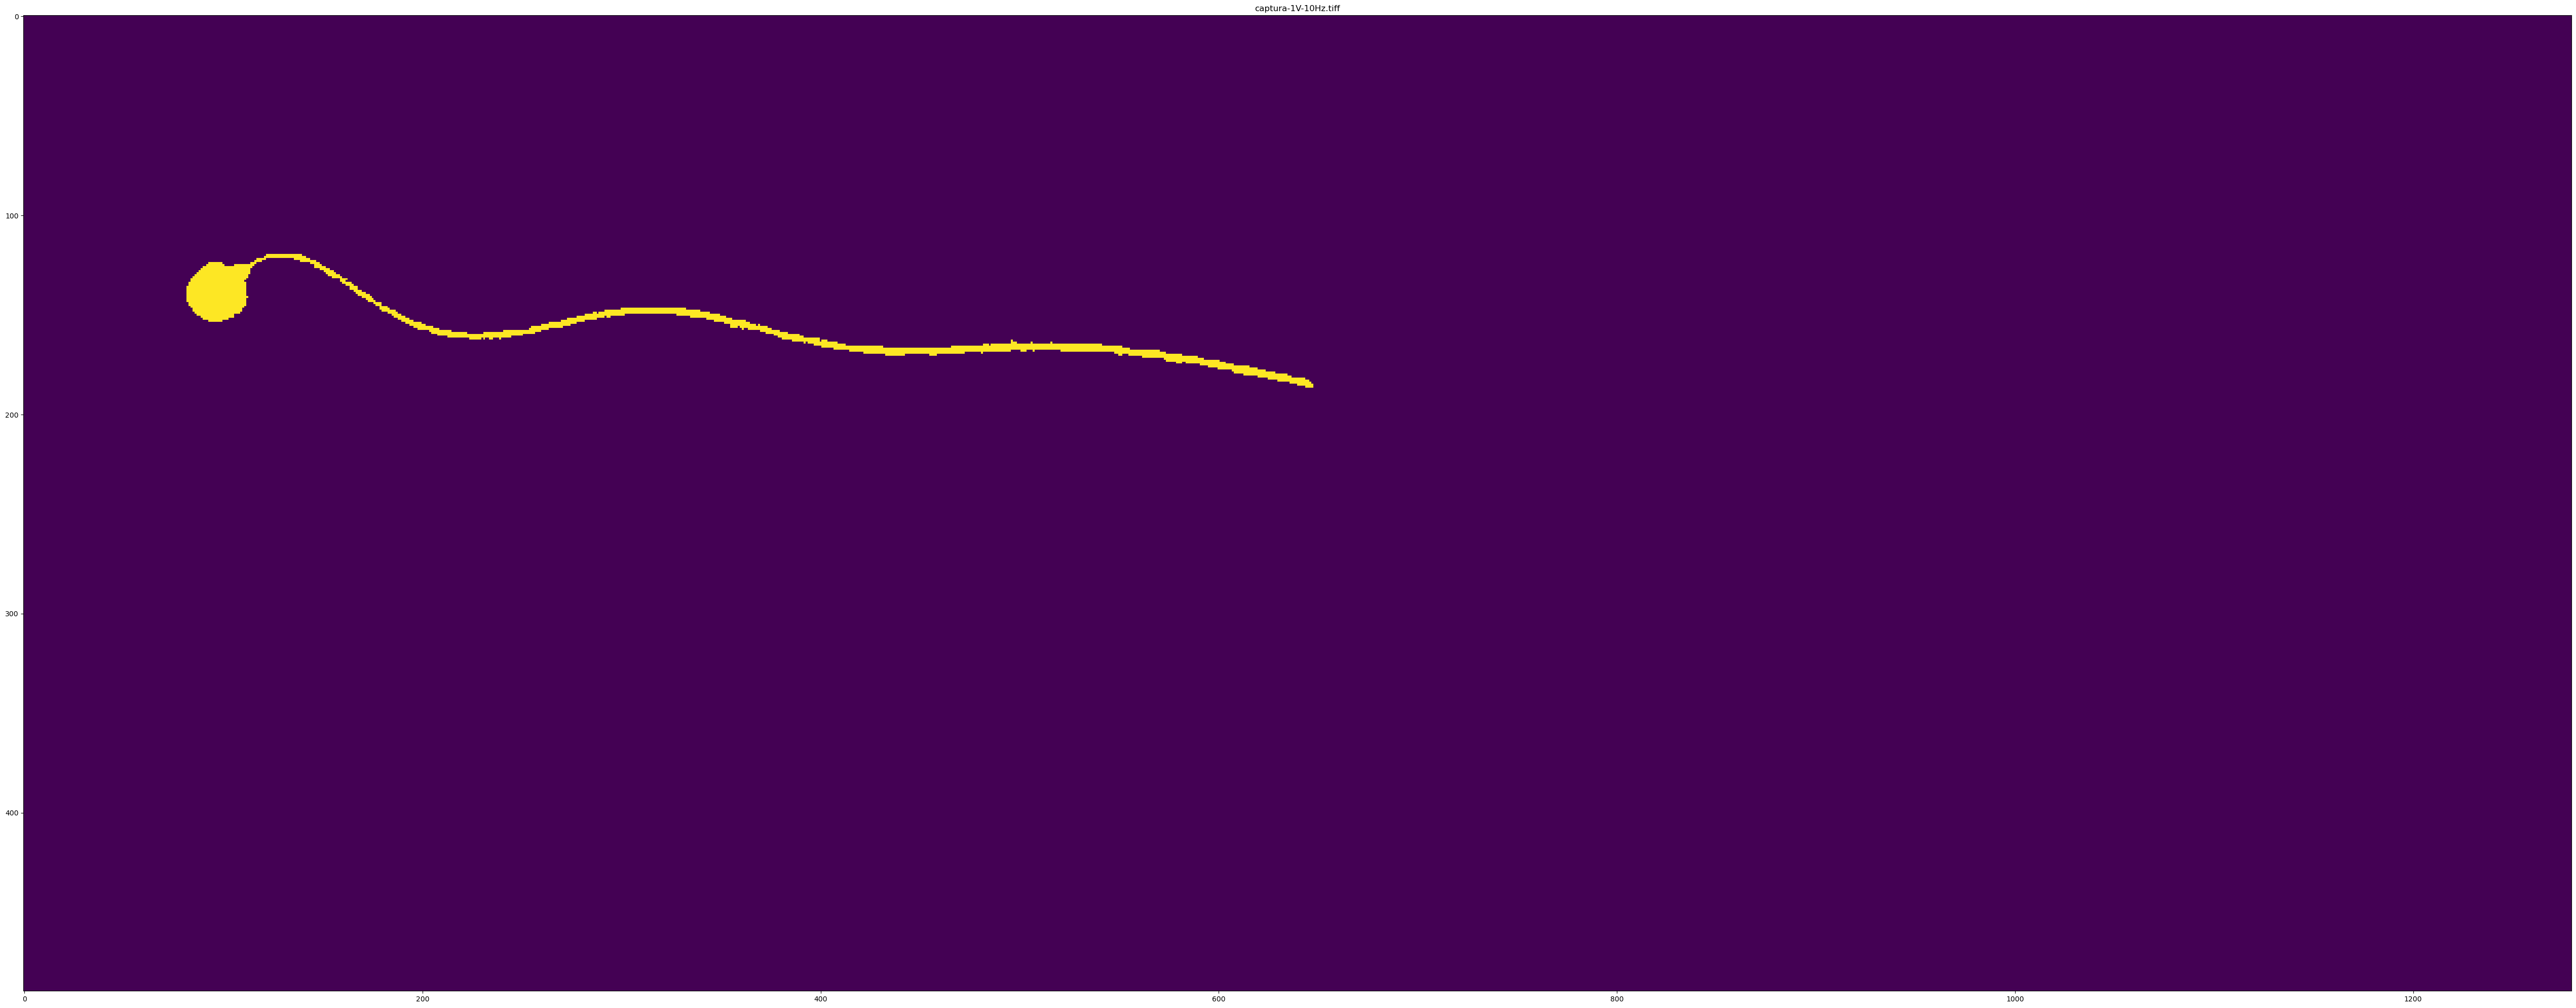

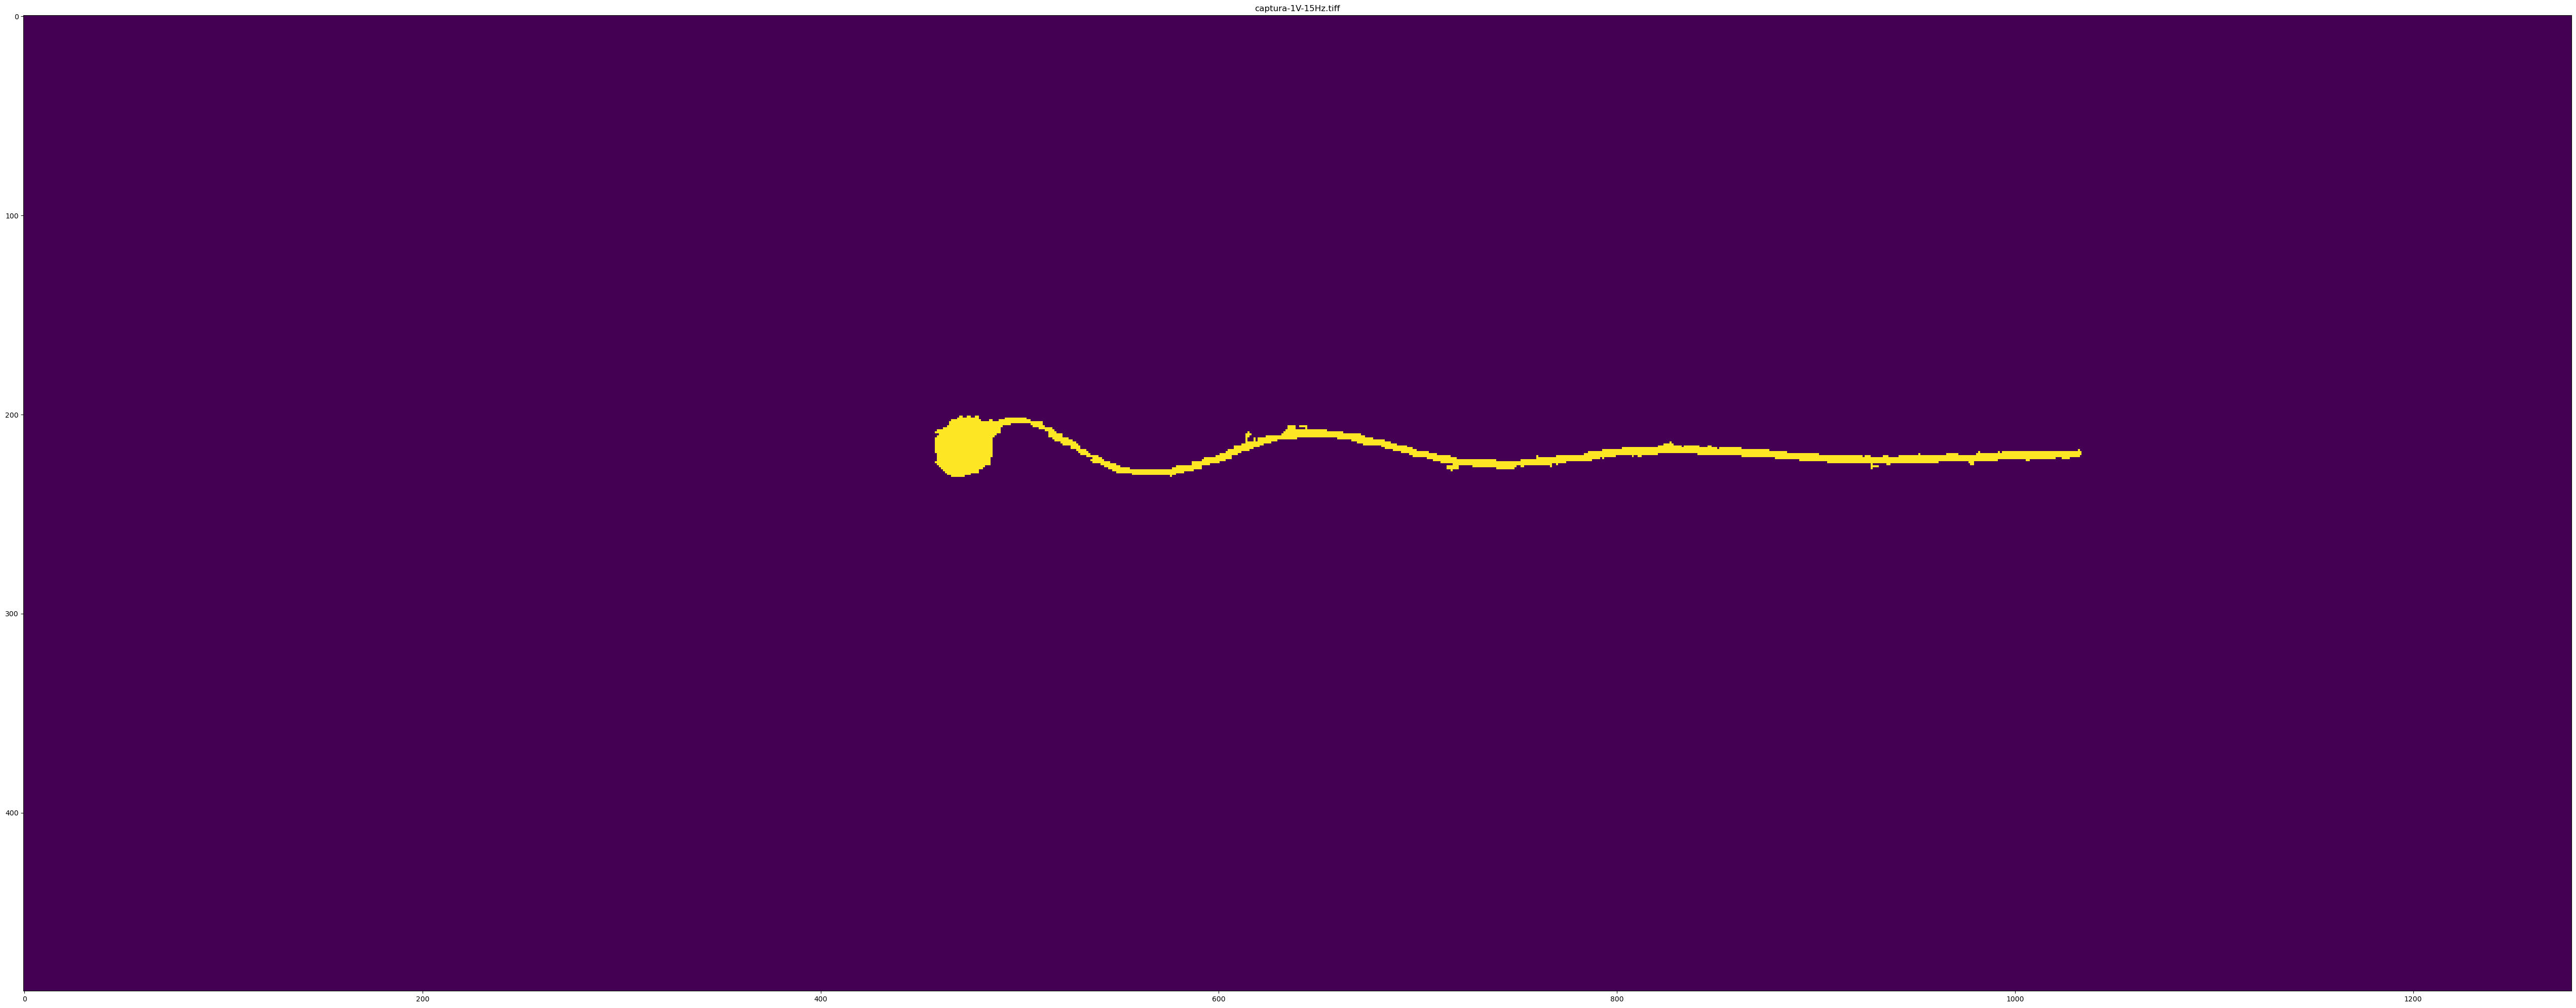

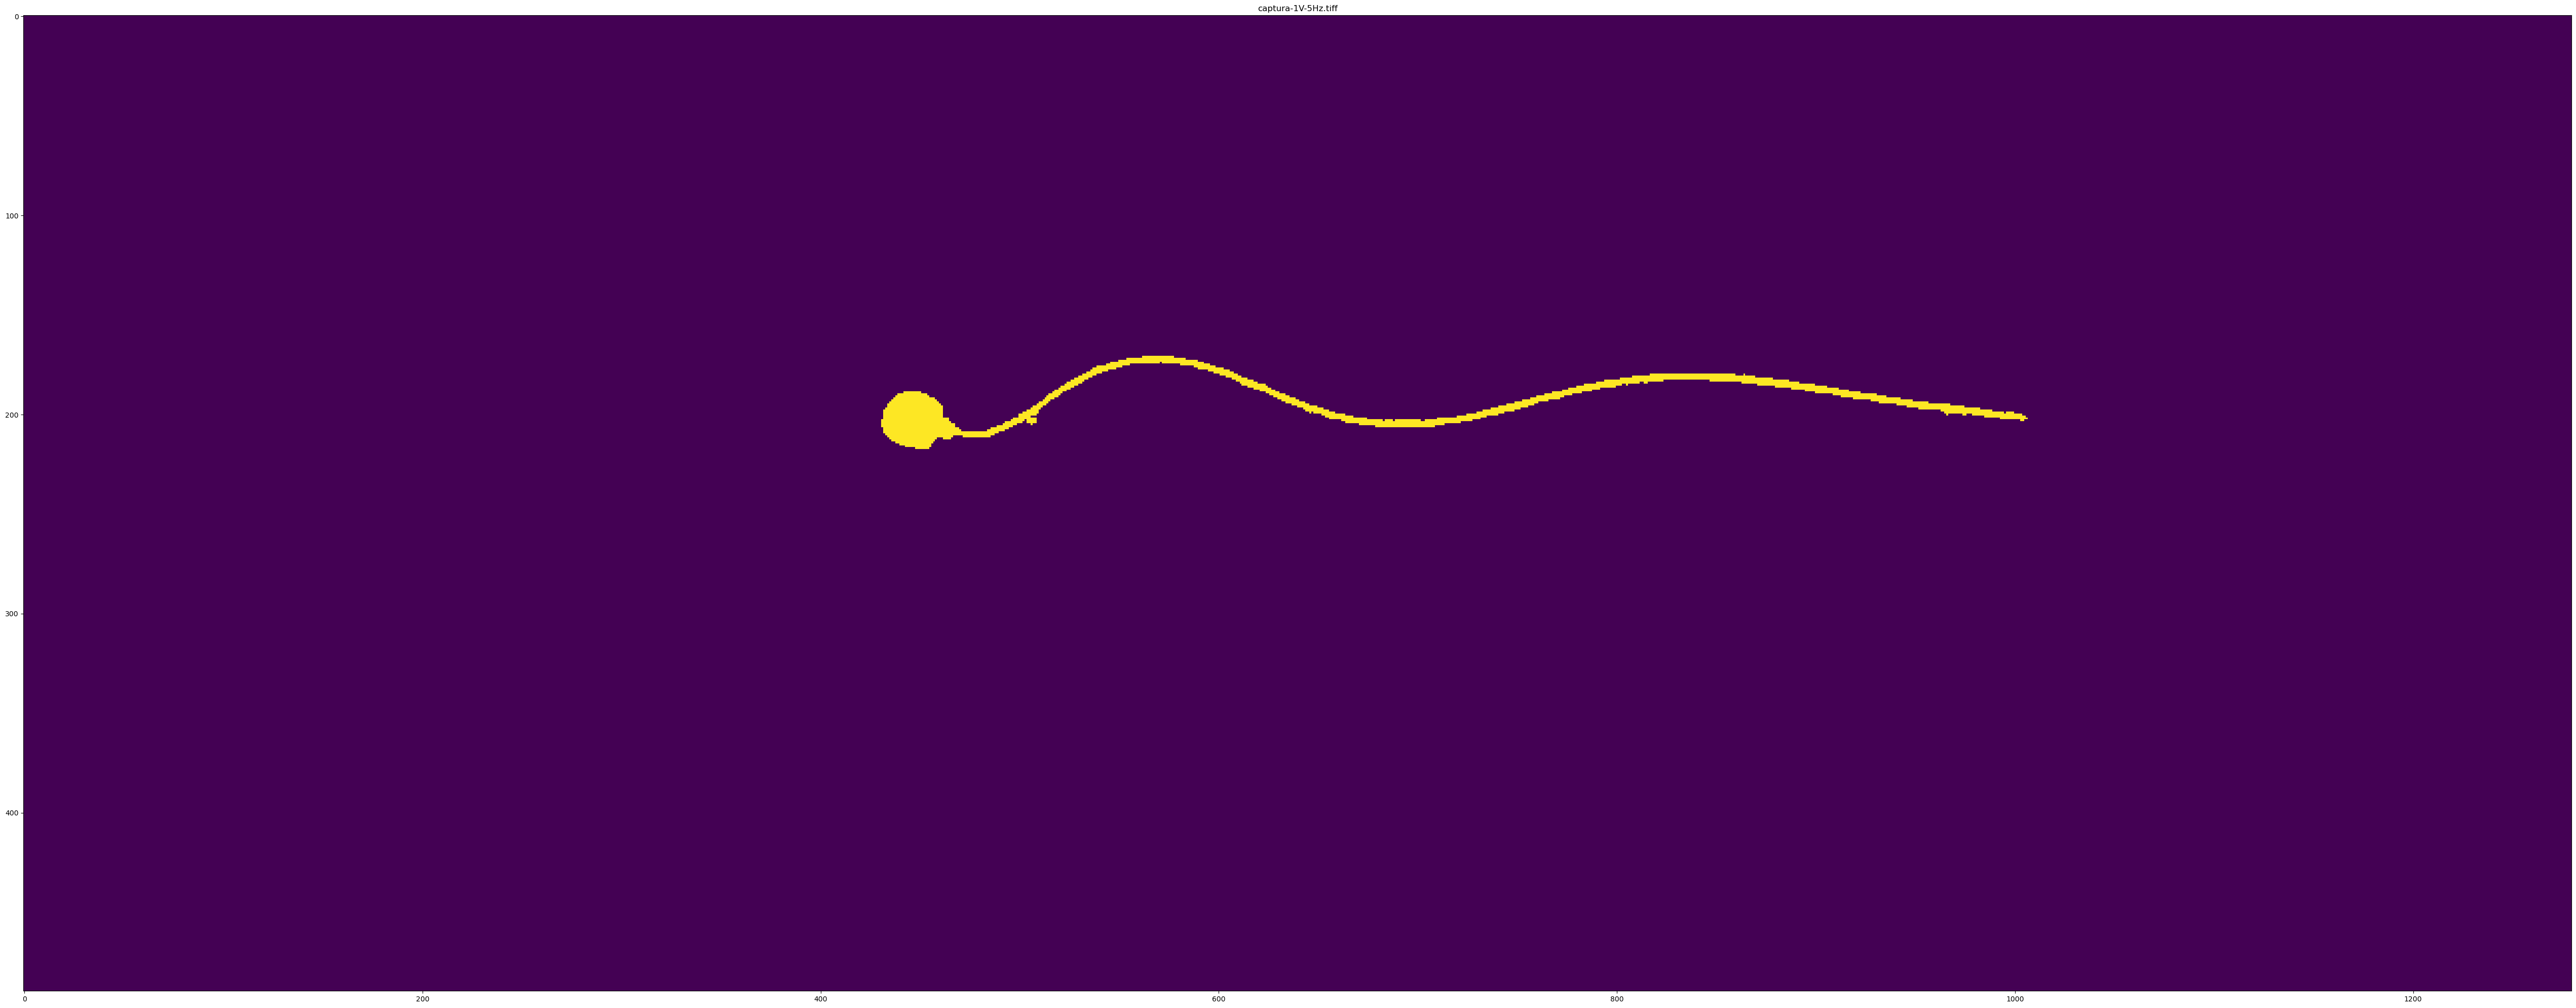

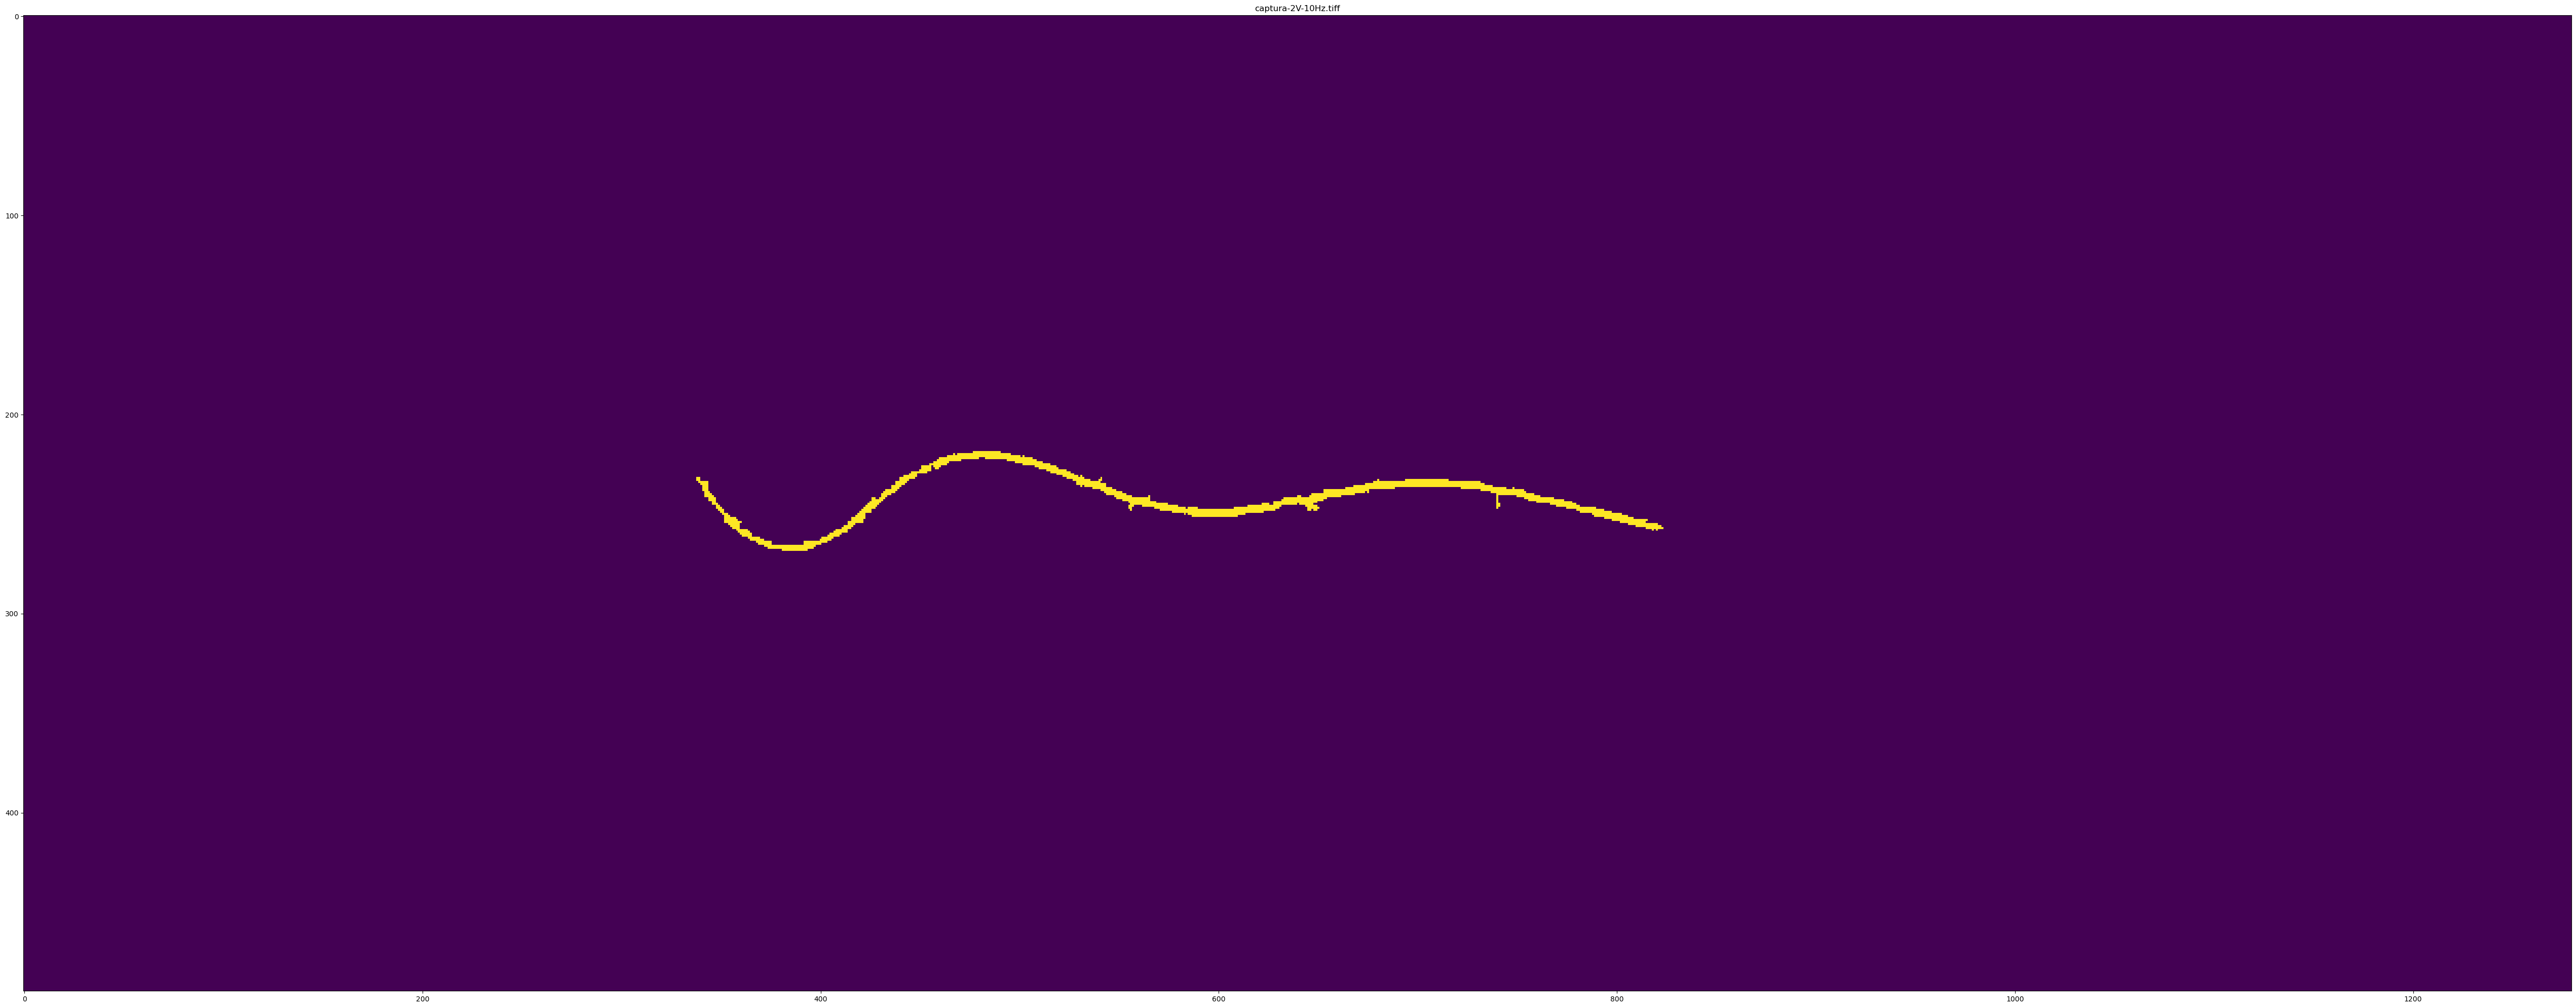

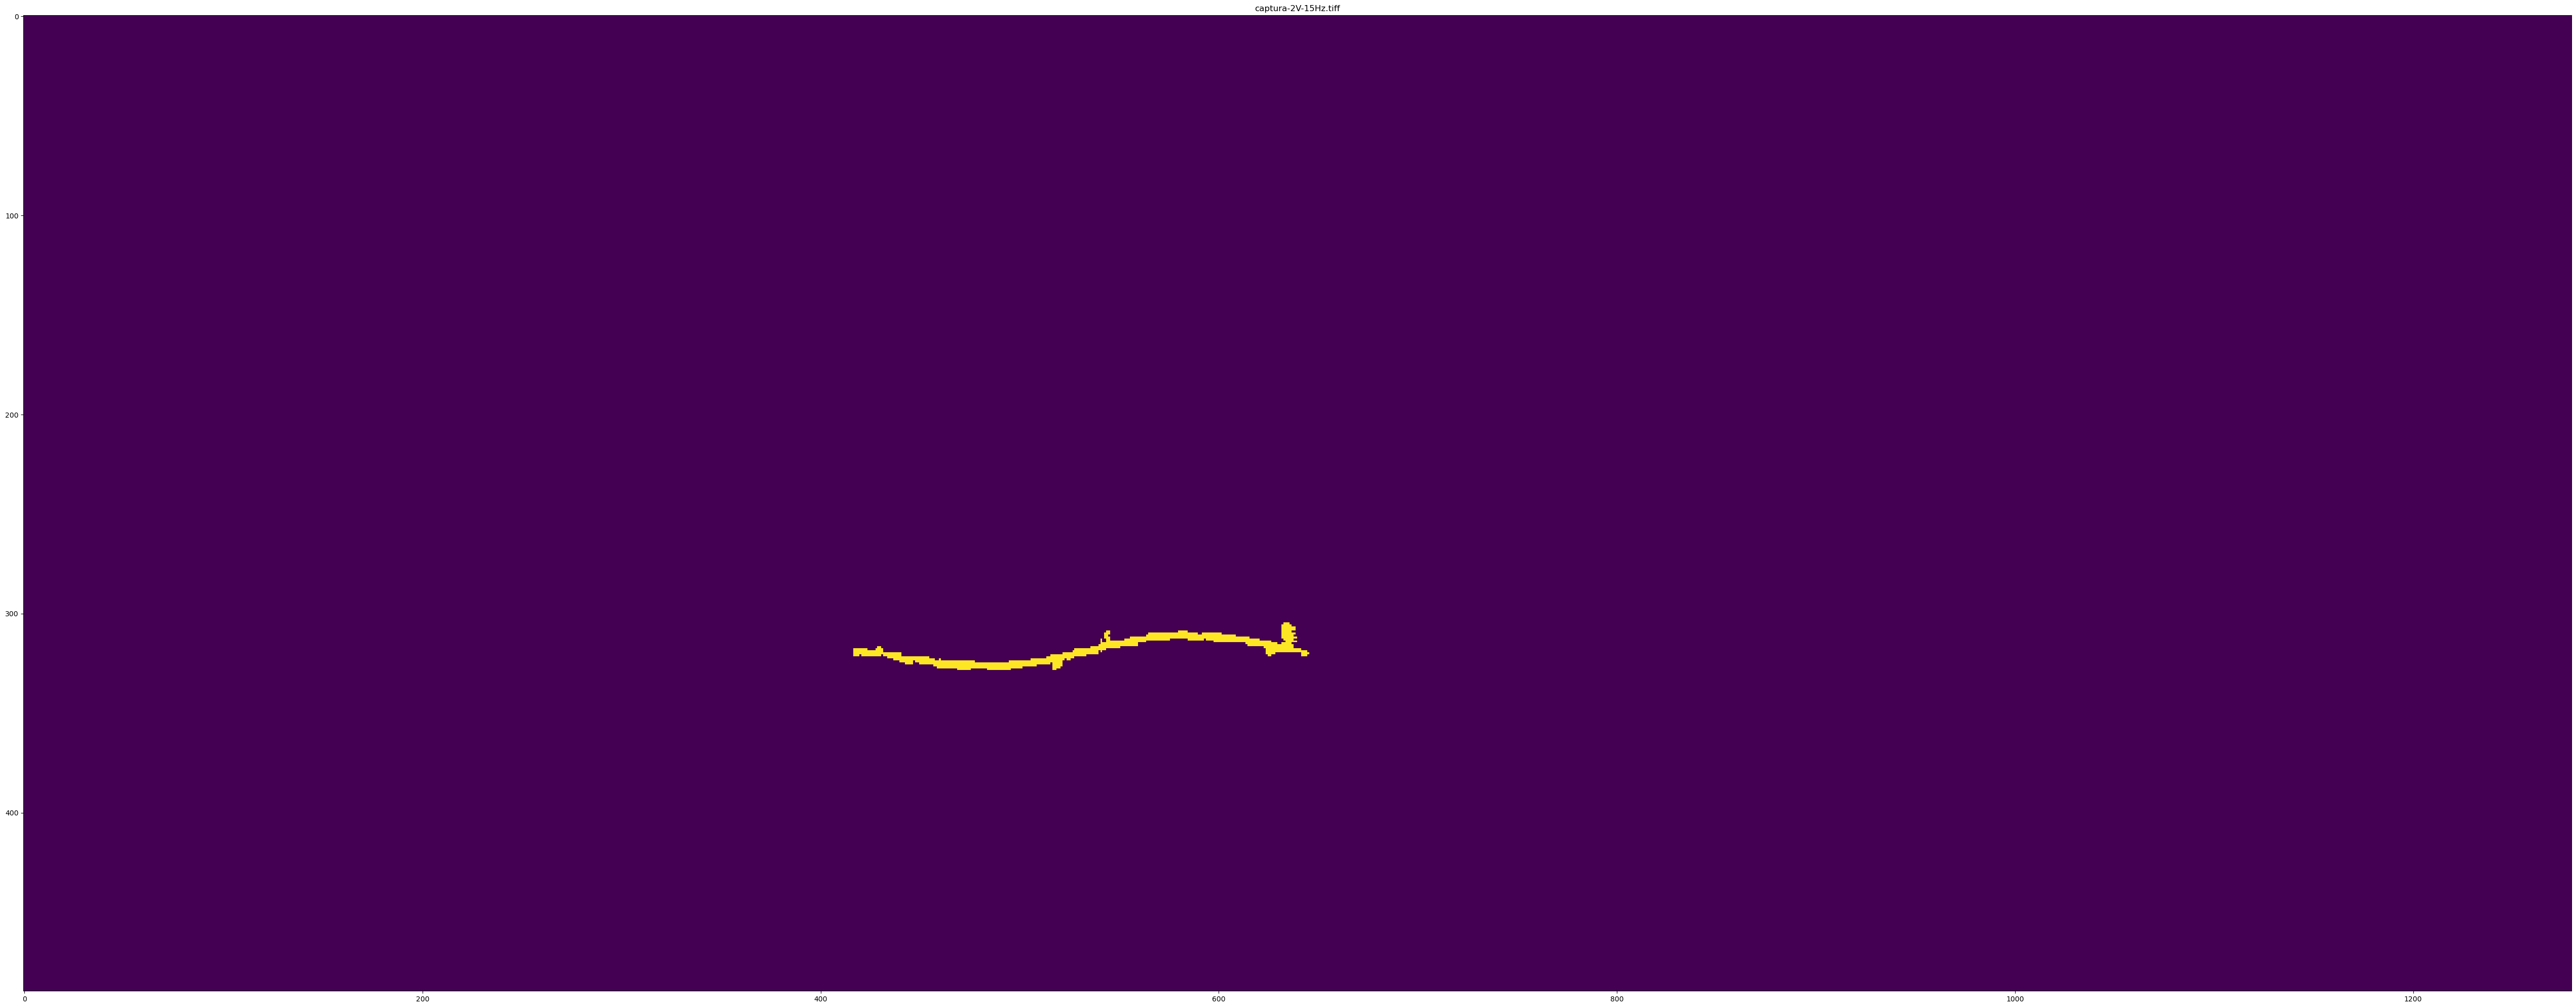

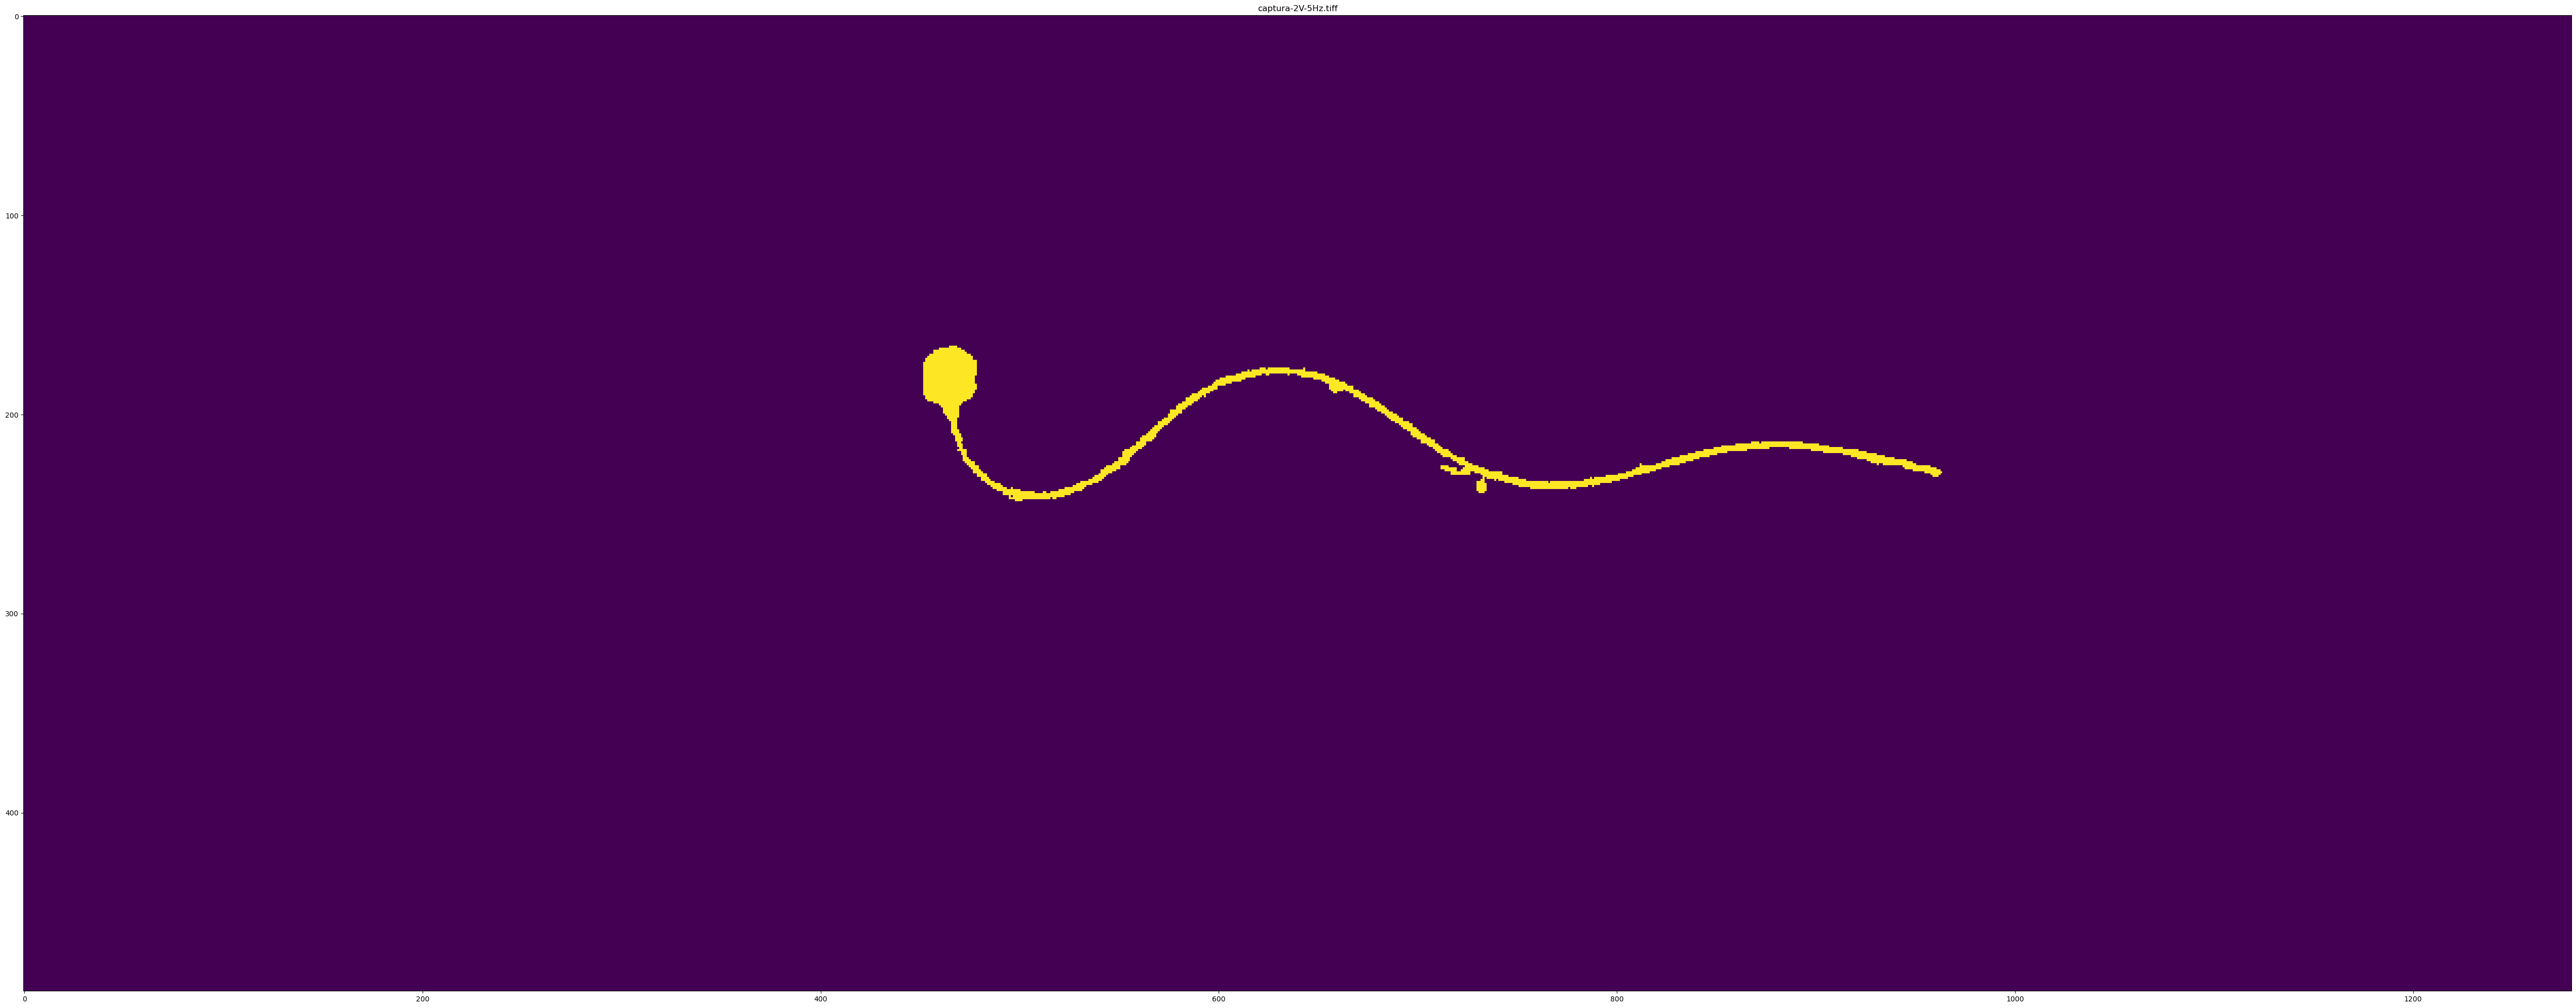

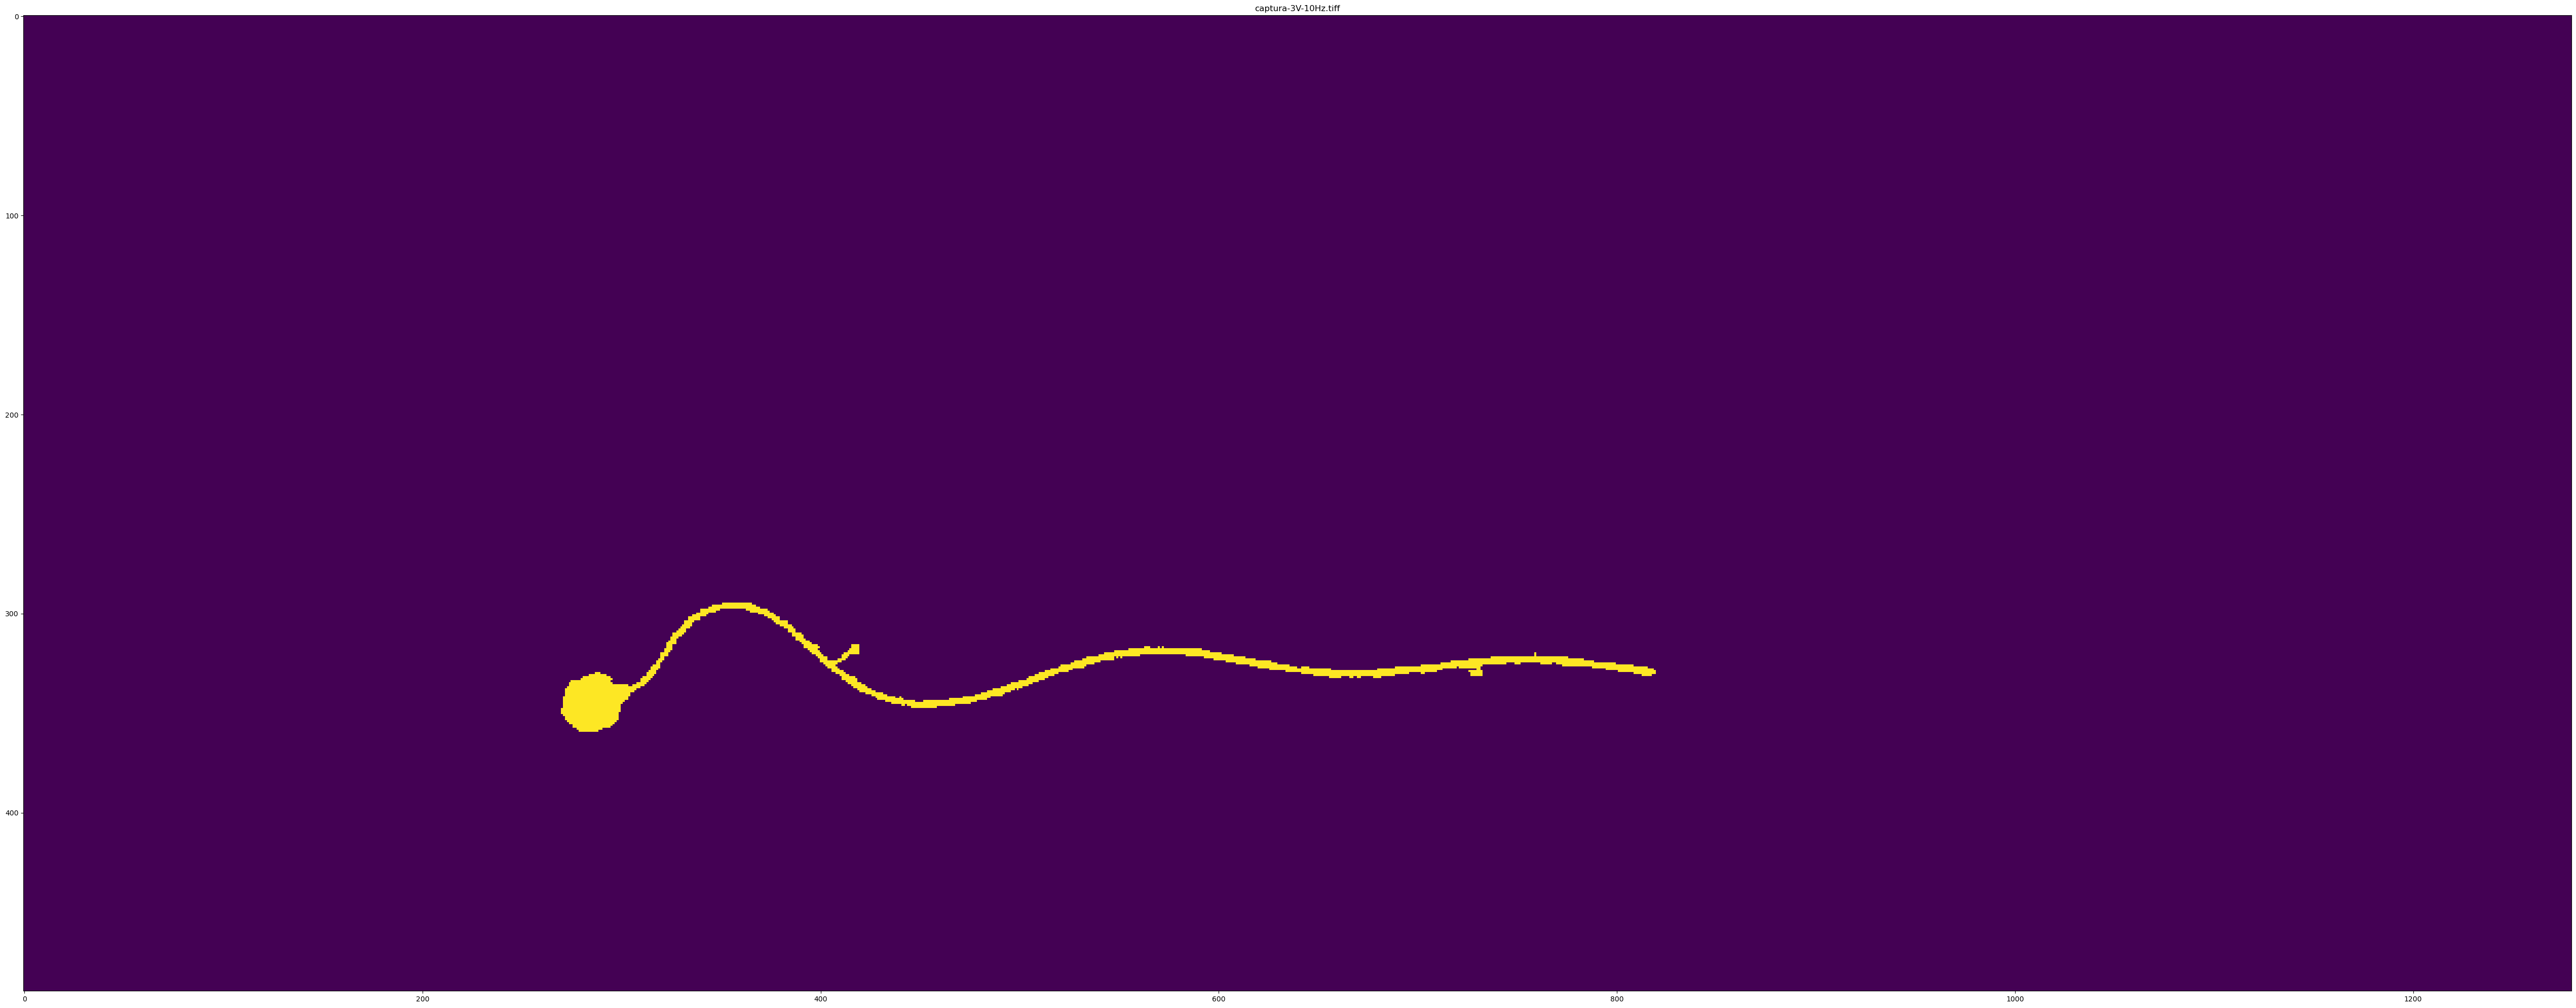

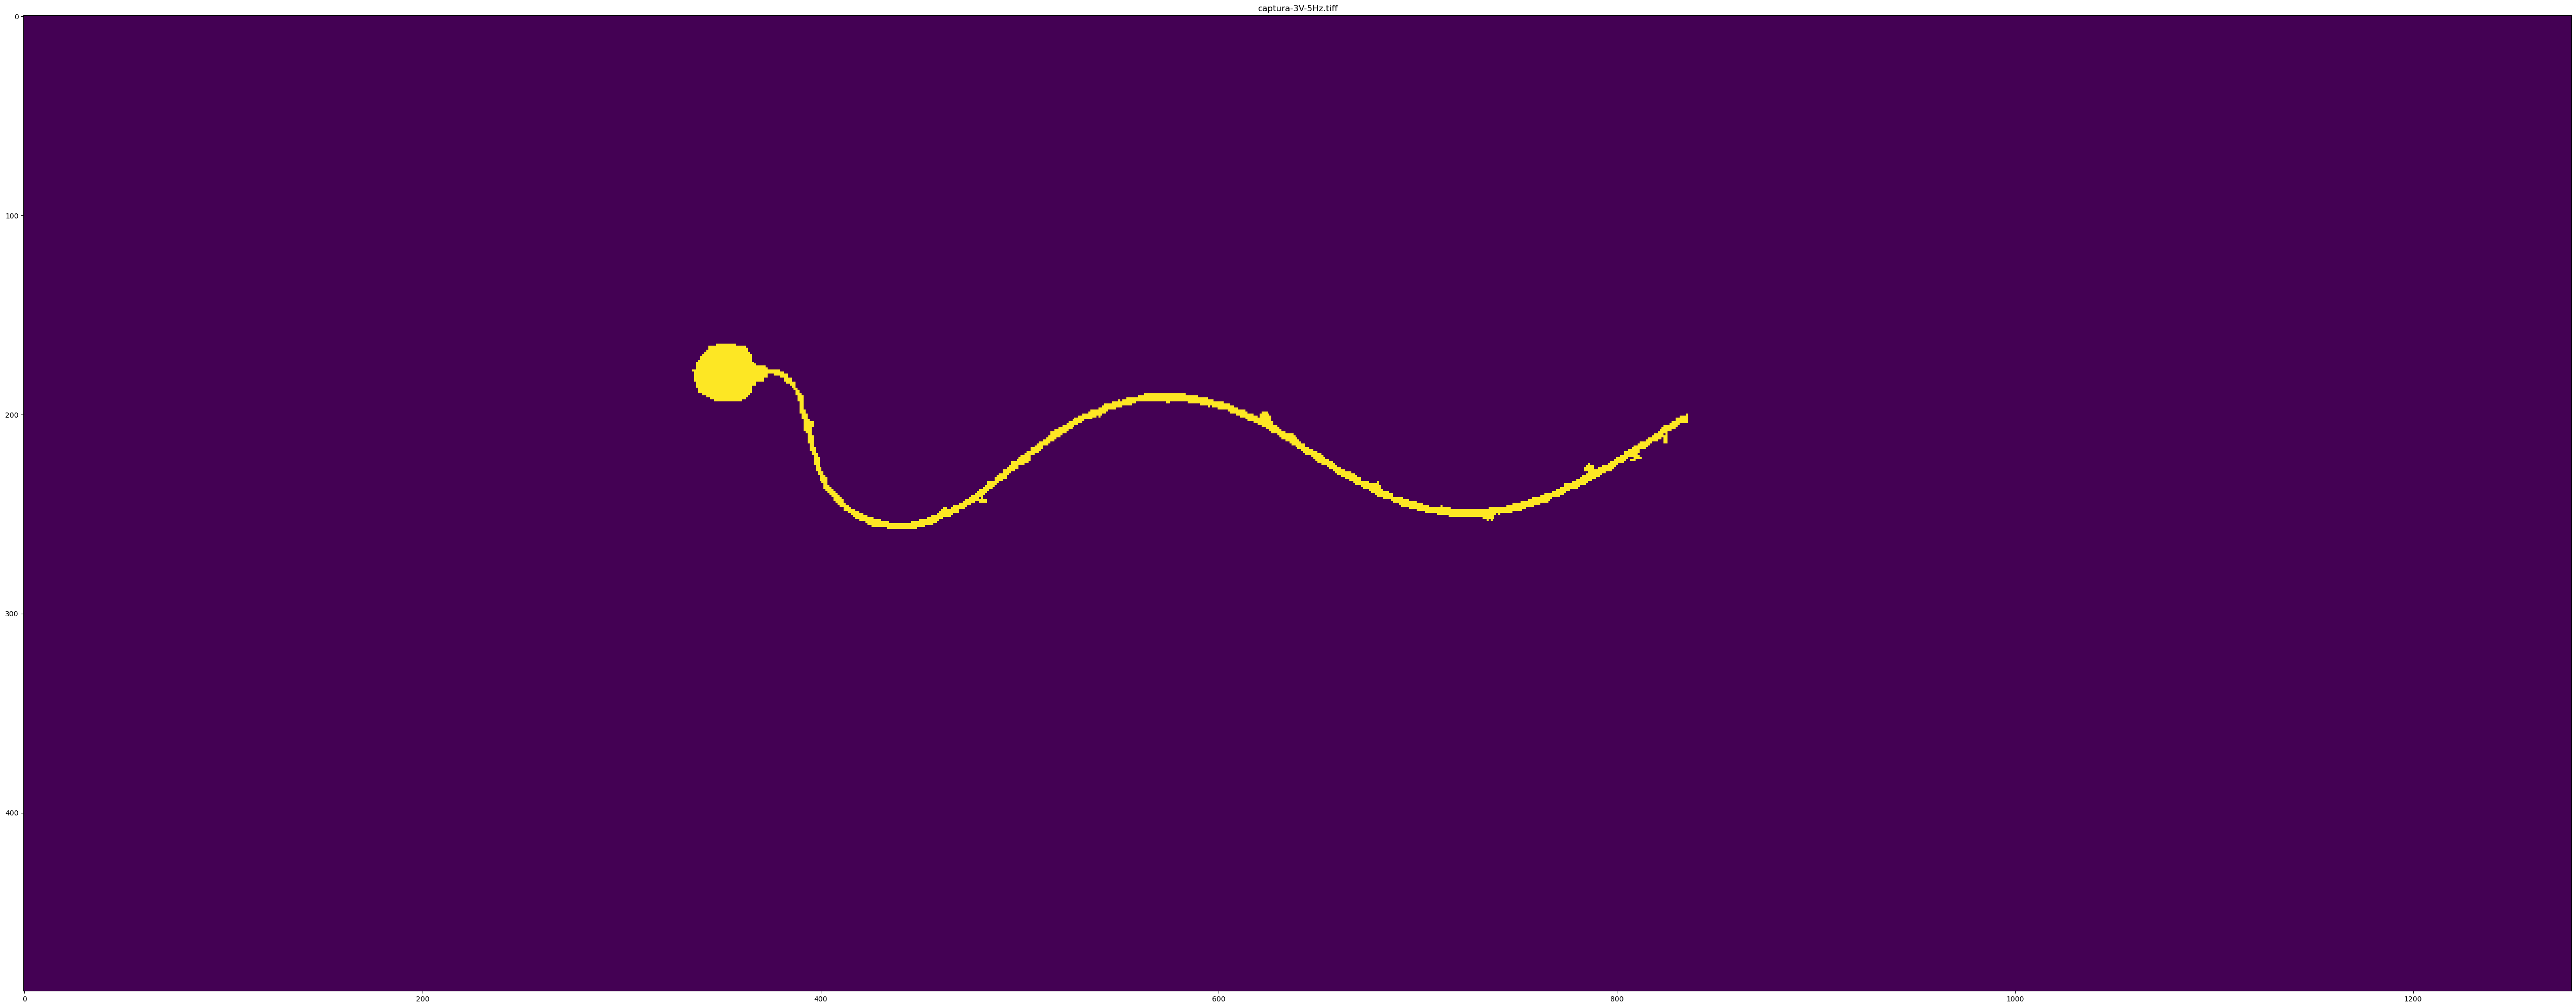

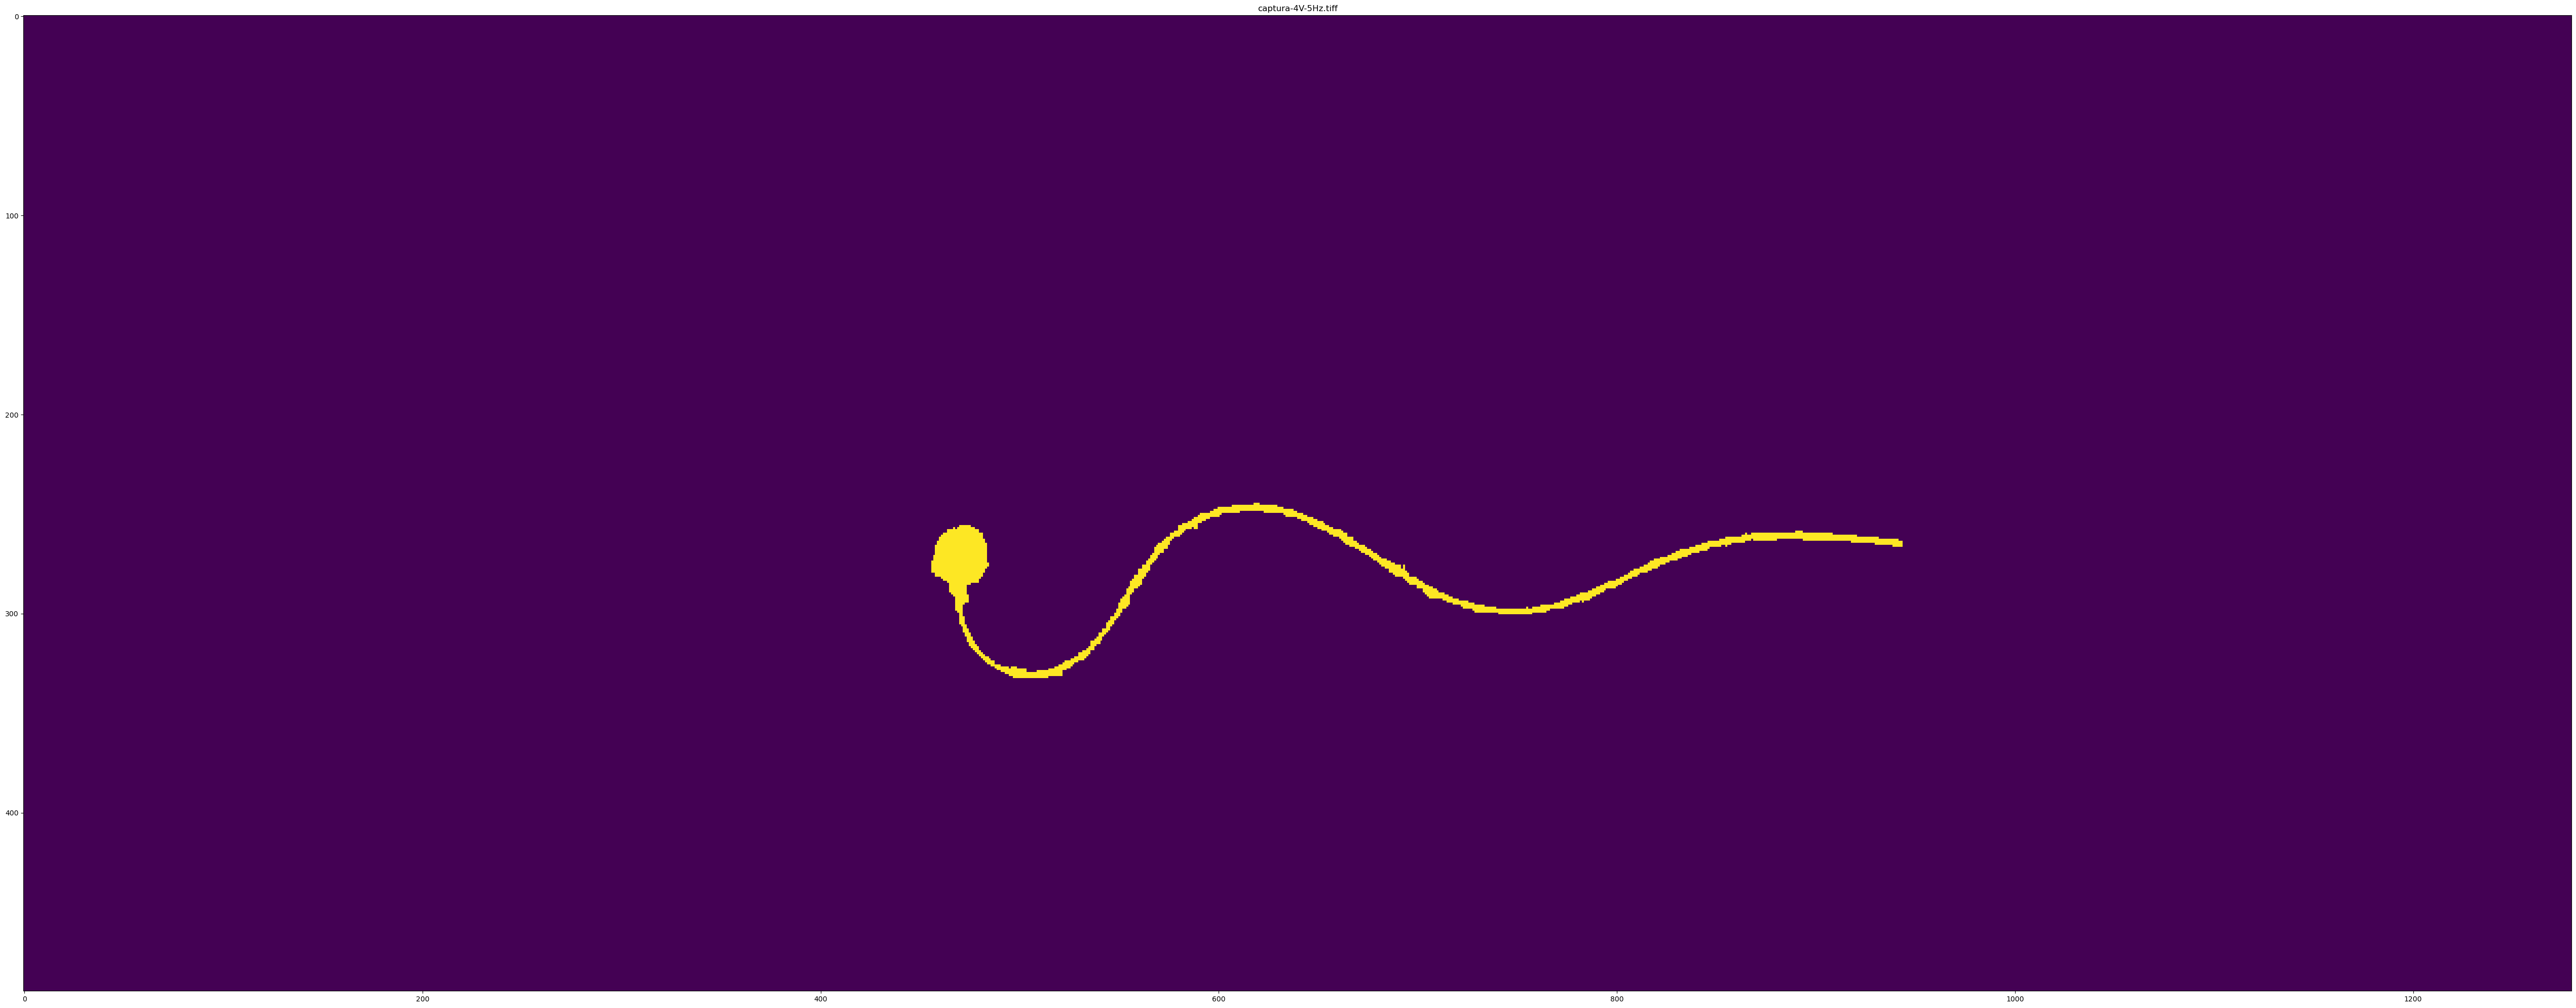

In [192]:
for filename in os.listdir('fotos\\capturas calibracion'):
    captura = skimage.io.imread(f'fotos\\capturas calibracion\\{filename}', dtype=float)
    ref_gray = gris(captura)
    
    # LO QUE CAMBIA QUE TAN ANCHO SALE ES EL THRESHOLD ACÁ
    _, ref_bin = cv.threshold(ref_gray, 110, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    
    labeled_image = label(1-ref_bin, connectivity=1)
    regions = regionprops(labeled_image)
    object_features = skimage.measure.regionprops(labeled_image)
    object_areas = [objf["area"] for objf in object_features]
    # print(object_areas)
    # print(object_areas[15])
    n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
    # print(sorted(object_areas, reverse=True)[:2])
    # print(object_areas[n])
    mask = np.zeros_like(labeled_image)
    mask += (labeled_image==n+1).astype(int)
    area  =  mask
    
    y, x = np.where(area!=0)
    
    captura[y, x] = [255,255,255]

    # cv.imwrite(f'fotos\\capturas calibracion\\perfiles\\perfil-{filename}', area)

    plt.figure(figsize=(300, 25))
    plt.title(f'{filename}')
    plt.imshow(area)

In [188]:
for filename in os.listdir('datos\\perfiles calibracion'):
    data = pd.read_csv(f'datos\\perfiles calibracion\\{filename}')
    px, value = data['Distance_(pixels)'], data['Gray_Value']
    sides = np.where(value==0)[0]
    diff = np.diff(sides)
    DIAMETRO_PX = np.max(diff)
    PX_PER_MM = DIAMETRO_PX/DIAMETRO_MM
    err = 1/DIAMETRO_MM
    print(f'{filename}\npx por mm: {PX_PER_MM} +- {err}')

Values-1V-10Hz.csv
px por mm: 15.64789456169089 +- 2.235413508812984
Values-1V-5Hz.csv
px por mm: 13.412481052877906 +- 2.235413508812984
Values-2V-10Hz.csv
px por mm: 15.64789456169089 +- 2.235413508812984
Values-2V-15Hz.csv
px por mm: 13.412481052877906 +- 2.235413508812984
Values-2V-5Hz.csv
px por mm: 13.412481052877906 +- 2.235413508812984
Values-3V-10Hz.csv
px por mm: 13.412481052877906 +- 2.235413508812984
Values-3V-5Hz.csv
px por mm: 13.412481052877906 +- 2.235413508812984
Values-4V-5Hz.csv
px por mm: 13.412481052877906 +- 2.235413508812984
